In [1]:
import json
import time
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pingouin as pg
from scipy import stats
import eventregistry as ER
from config import API_KEY


FIGSIZE = plt.rcParams['figure.figsize']
FIGSIZE

[6.4, 4.8]

## Celebrities

In [2]:
celeb = pd.read_csv('data/celebrities.csv', index_col='name', parse_dates=['death'])
celeb.tail()

,nationality,gender,industry,death,age,cause,unexpected,controversial,url
name,,,,,,,,,
Betty Williams,Northern Irish,female,academia,2020-03-17,76,pneumonia,0,0,https://en.wikipedia.org/wiki/Betty_Williams
Ahmed Zewail,"Egyptian, American",male,academia,2016-08-02,70,undisclosed,0,1,https://en.wikipedia.org/wiki/Ahmed_Zewail
John Forbes Nash Jr.,American,male,academia,2015-05-23,86,accident,1,1,https://en.wikipedia.org/wiki/John_Forbes_Nash...
Elie Wiesel,"Romanian, American",male,academia,2016-07-02,87,illness,0,1,https://en.wikipedia.org/wiki/Elie_Wiesel
Simone Veil,French,female,politics,2017-06-30,89,undisclosed,0,1,https://en.wikipedia.org/wiki/Simone_Veil


## Selection of the period of interest

In [7]:
trends_dict = {}

for row in celeb.itertuples():

    # reading Google Trends datasets
    trends = pd.read_csv(f'data/trends/{row.Index}.csv', header=1, index_col='Month', parse_dates=['Month'])
    trends.index = trends.index.to_period('M')
    trends.columns.values[0] = 'interest'
    trends['interest'] = trends['interest'].replace('<1', '0')
    trends['interest'] = pd.to_numeric(trends['interest'])
    
    # number of months relative to death date
    trends['months_relative_to_death'] = trends.index - celeb.at[row.Index, 'death'].to_period('M')
    trends['months_relative_to_death'] = trends['months_relative_to_death'].apply(lambda x: x.n)
    trends_dict[row.Index] = trends

    # setting pre-death period
    if row.death.year != 2014:
        trends_from_2014 = trends[trends.index >= '2014-01-01']
        pre_death_period = trends_from_2014[trends_from_2014.index < row.death.to_period('M')].nlargest(1, 'interest', keep='last').index
        
        if pre_death_period.year != row.death.year:
            pre_death_time_stamp = pre_death_period.to_timestamp()
            pre_death_start = (pre_death_time_stamp - pd.offsets.YearBegin())[0]
            pre_death_end = (pre_death_time_stamp + pd.offsets.YearEnd())[0]
        else:
            pre_death_start = pd.Timestamp(row.death.year - 1, 1, 1)
            pre_death_end = pd.Timestamp(row.death.year - 1, 12, 31)
    
    else:
        pre_death_start = pd.Timestamp(2014, 1, 1)
        pre_death_end = row.death - pd.DateOffset(days=1)
    
    celeb.at[row.Index, 'pre_death_start'] = pre_death_start
    celeb.at[row.Index, 'pre_death_end'] = pre_death_end

In [8]:
# setting post-death period
celeb['post_death_start'] = celeb['death'].apply(lambda x: pd.Timestamp(x.year + 1, 1, 1) if x.year != 2023 else x + pd.DateOffset(months=1))
celeb['post_death_end'] = celeb['death'].apply(lambda x: pd.Timestamp(x.year + 1, 12, 31) if x.year != 2023 else x + pd.DateOffset(years=1, months=1))
celeb['keywords'] = celeb.index.str.split(' ')
celeb.head()

,nationality,gender,industry,death,age,cause,unexpected,controversial,url,pre_death_start,pre_death_end,post_death_start,post_death_end,keywords
name,,,,,,,,,,,,,,
Matthew Perry,"Canadian, American",male,cinema,2023-10-28,54,ketamine medication,1,1,https://en.wikipedia.org/wiki/Matthew_Perry,2021-01-01,2021-12-31,2023-11-28,2024-11-28,"[Matthew, Perry]"
Silvio Berlusconi,Italian,male,politics,2023-06-12,86,illness,0,1,https://en.wikipedia.org/wiki/Silvio_Berlusconi,2022-01-01,2022-12-31,2023-07-12,2024-07-12,"[Silvio, Berlusconi]"
Pervez Musharraf,Pakistani,male,politics,2023-02-05,79,illness,0,1,https://en.wikipedia.org/wiki/Pervez_Musharraf,2019-01-01,2019-12-31,2023-03-05,2024-03-05,"[Pervez, Musharraf]"
Ken Block,American,male,sport,2023-01-02,55,accident,1,0,https://en.wikipedia.org/wiki/Ken_Block,2014-01-01,2014-12-31,2023-02-02,2024-02-02,"[Ken, Block]"
Pope Benedict XVI,German,male,papacy,2022-12-31,95,illness,0,1,https://en.wikipedia.org/wiki/Pope_Benedict_XVI,2019-01-01,2020-12-31,2023-01-01,2023-12-31,"[Pope, Benedict, XVI]"


In [9]:
# celeb['pre_death_start'] = celeb['pre_death_start'].apply(lambda x: pd.Timestamp(x.year - 1, 1, 1))
# celeb['pre_death_end'] = celeb['pre_death_end'].apply(lambda x: pd.Timestamp(x.year - 1, 12, 31))
# for row in celeb.itertuples():
#     name = row.Index
#     if celeb.at[name, 'death'].year == celeb.at[name, 'pre_death_end'].year:
#         celeb.at[name, 'pre_death_end'] = pd.Timestamp(celeb.at[name, 'death'].year, celeb.at[name, 'death'].month, celeb.at[name, 'death'].day - 1)
# celeb

In [10]:
# celeb['post_death_start'] = celeb['post_death_start'].apply(lambda x: pd.Timestamp(x.year + 1, 1, 1))
# celeb['post_death_end'] = celeb['post_death_end'].apply(lambda x: pd.Timestamp(2024, 12, 31))

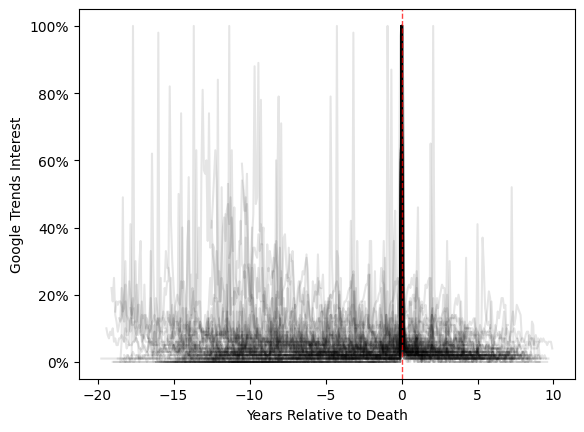

In [11]:
import matplotlib.ticker as mtick

fig, ax = plt.subplots()
for name in celeb.index:
    trends = trends_dict[name]
    ax.plot(trends['months_relative_to_death'] / 12, trends['interest'], color='k', alpha=.1)

ax.axvline(0, linewidth=1, linestyle='--', color='r', alpha=.75)
ax.set_xlabel('Years Relative to Death')
ax.set_ylabel('Google Trends Interest')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.savefig('plots/trends_interest.pdf', bbox_inches='tight', pad_inches=0)

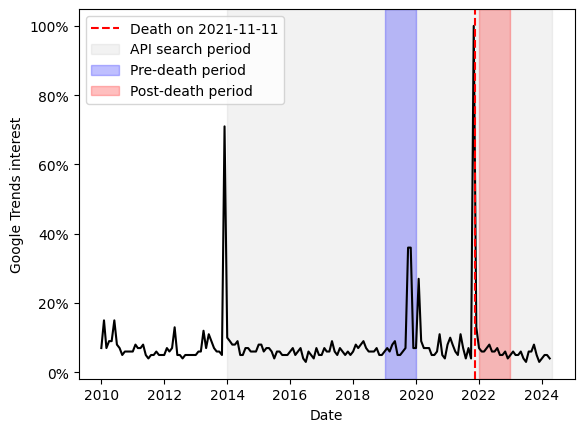

In [8]:
name = 'F.W. de Klerk'
trends = trends_dict[name]
trends = trends[trends.index >= '2010-01-01']

fig, ax = plt.subplots()
ax.plot(trends.index.to_timestamp(), trends['interest'], color='k')
ax.axvline(pd.to_datetime(celeb.at[name, 'death']), color='r', linestyle='--', label=f'Death on {celeb.at[name, 'death'].date()}')
ax.axvspan(pd.to_datetime('2014-01-01'), trends.index[-1], label='API search period', color='k', alpha=.05)
ax.axvspan(celeb.at[name, 'pre_death_start'], celeb.at[name, 'pre_death_end'], color='b', alpha=.25, label='Pre-death period')
ax.axvspan(celeb.at[name, 'post_death_start'], celeb.at[name, 'post_death_end'], color='r', alpha=.25, label='Post-death period')
ax.set_xlabel('Date')
ax.set_ylabel('Google Trends interest')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend()

plt.savefig('plots/period_select.pdf', bbox_inches='tight', pad_inches=0)

## Event Registry API

In [9]:
er = ER.EventRegistry(apiKey=API_KEY, allowUseOfArchive=True)

In [10]:
def query(row, period_start, period_end):
    """Make query request."""
    return ER.QueryArticlesIter(
        keywords=ER.QueryItems.OR(row.keywords),
        conceptUri=row.url,
        categoryUri=er.getCategoryUri(row.industry) if '(' in row.Index else None,  # keep it?
        lang="eng",
        dateStart=period_start,
        dateEnd=period_end,
        keywordsLoc="title",
        isDuplicateFilter="skipDuplicates",
        # endSourceRankPercentile=10,
        dataType=["news", "pr", "blog"]
    )

In [11]:
def exec_query(q, data_dict: defaultdict, name: str, period: str) -> None:
    """Execute query q and append articles to data dict."""
    for art in q.execQuery(er,
                           sortBy="rel",
                           returnInfo=ER.ReturnInfo(
                               articleInfo=ER.ArticleInfoFlags(socialScore=True, sentiment=True),
                               sourceInfo=ER.SourceInfoFlags(description=True, location=True, ranking=True, socialMedia=True),
                               ),
                            maxItems=500):
        data_dict[name][period].append(art)

In [12]:
article_counts = pd.read_csv('data/article_counts.csv', index_col='name')
article_counts.head()

,pre_death,post_death,total
name,,,
Kobe Bryant,6114,8158,14272
Elizabeth II,8559,4304,12863
Pope Benedict XVI,2994,5059,8053
Carrie Fisher,885,5018,5903
Fidel Castro,3596,1385,4981


In [13]:
# data_dict = defaultdict(lambda: defaultdict(list))

# for row in celeb.itertuples():
#     print(row.Index)

#     q = query(row, period_start=row.pre_death_start, period_end=row.pre_death_end)
#     pre_death_count = q.count(er)
#     print('pre-death:', pre_death_count)
#     article_counts.at[row.Index, 'pre_death'] = pre_death_count
#     if pre_death_count > 0:
#         exec_query(q, data_dict=data_dict, name=row.Index, period='pre_death')

#     q = query(row, period_start=row.post_death_start, period_end=row.post_death_end)
#     post_death_count = q.count(er)
#     print('post-death:', post_death_count)
#     article_counts.at[row.Index, 'post_death'] = post_death_count
#     if post_death_count > 0:
#         exec_query(q, data_dict=data_dict, name=row.Index, period='post_death')

0.7674755551119329

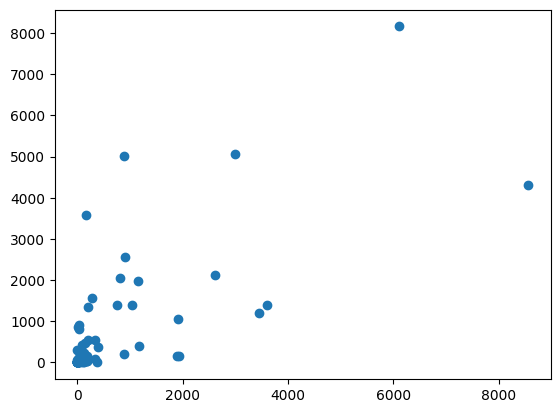

In [14]:
article_counts['total'] = article_counts['pre_death'] + article_counts['post_death']
article_counts = article_counts.sort_values('total', ascending=False)
article_counts.to_csv('data/article_counts.csv')

plt.scatter(article_counts['pre_death'], article_counts['post_death'])
article_counts['pre_death'].corr(article_counts['post_death'], method='spearman')

In [15]:
# file_name = f'data/articles_{int(time.time())}.json'

# with open(file_name, 'w') as json_file:
#    json.dump(data_dict, json_file)

# with open(file_name, 'r') as json_file:
#    data_dict = json.load(json_file)

In [16]:
data_dict = defaultdict(lambda: defaultdict(list))

file_names = ['articles_1714670753', 'articles_1714740288', 'articles_1714740805', 'articles_1714749213', 'articles_1715179619', 'articles_1715180565', 'articles_1715182374', 'articles_1715182980', 'articles_1716223400', 'articles_1716223776', 'articles_1716225390', 'articles_1716225630', 'articles_1716491475', 'articles_1716491738', 'articles_1716492082', 'articles_1714654950']

for file_name in file_names:

    with open(f'data/{file_name}.json', 'r') as json_file:
        new_dict = json.load(json_file)

    for name, value in new_dict.items():
        for period, articles in value.items():
            data_dict[name][period].extend(articles)

with open('data/articles_final.json', 'w') as json_file:
   json.dump(data_dict, json_file)

In [17]:
with open('data/articles_final.json', 'r') as json_file:
    data_dict = json.load(json_file)

In [18]:
data_list = []

for name, value in data_dict.items():
    for period, articles in value.items():
        for art in articles:
        
            data_list.append({
                'name': name,
                'period': period,
                'uri': art['uri'],
                'datetime': art['dateTime'],
                'data_type': art['dataType'],
                'sim': art['sim'],
                'url': art['url'],
                'title': art['title'],
                'body': art['body'],
                'shares': art['shares'],
                'sentiment': art['sentiment'],
                'event_uri': art['eventUri'],
                'relevance': art['relevance'],
                'source_uri': art['source']['uri'],
                'source_title': art['source']['title'],
                'source_desc': art['source']['description'],
                'source_loc': art['source']['location']['label']['eng'] if art['source']['location'] is not None else None,
                'source_importance_rank': art['source']['ranking']['importanceRank'],
                'source_alexa_global_rank': art['source']['ranking'].get('alexaGlobalRank'),
                'source_alexa_country_rank': art['source']['ranking'].get('alexaCountryRank'),
            })

articles = pd.DataFrame(data_list)
articles.to_csv('data/articles.csv', index=False)

### Celebrity filter

In [19]:
articles = pd.read_csv('data/articles.csv', parse_dates=['datetime'])
articles = articles.rename({'period': 'Period'}, axis=1)
articles['Period'] = articles['Period'].str.capitalize()
articles['Period'] = articles['Period'].str.replace('_', '-')
print(len(articles))
articles.head(2)

32668


,name,Period,uri,datetime,data_type,sim,url,title,body,shares,sentiment,event_uri,relevance,source_uri,source_title,source_desc,source_loc,source_importance_rank,source_alexa_global_rank,source_alexa_country_rank
0,Jiang Zemin,Pre-death,241680688,2015-01-23 06:07:00+00:00,news,0.0,http://www.theepochtimes.com/n3/1205750-jiang-...,Jiang Zemin's Son Suspected of Buying Support ...,Mainland Chinese media have been speculating a...,{'facebook': 11},-0.513725,NaN,200,theepochtimes.com,The Epoch Times,Epoch Times is an independent voice in print &...,"Plano, Texas",23,1651.0,233.0
1,Jiang Zemin,Pre-death,325617407,2015-10-21 17:50:00+00:00,news,0.0,http://sinosphere.blogs.nytimes.com/2015/10/20...,This -- Ridicule Turns to Affection as Chinese...,"Read in Chinese | 点击查看本文中文版\n\nFor years, he w...",{},0.231373,NaN,134,sinosphere.blogs.nytimes.com,The New York Times,Where the conversation begins. Follow for brea...,New York City,33,120.0,32.0


In [20]:
celeb['pre_end_max'] = celeb['death'] - pd.DateOffset(days=1)
celeb['post_start_min'] = celeb['death'] + pd.DateOffset(months=1)

articles = articles.merge(celeb[['pre_end_max', 'post_start_min']], left_on='name', right_index=True)
articles = articles[(articles['datetime'].dt.date <= articles['pre_end_max']) | (articles['datetime'].dt.date >= articles['post_start_min'])]

In [21]:
articles = articles.drop_duplicates()

In [22]:
# Fill na sentiment for Florence Henderson in the pre_death period since too few articles
mask = (articles['name'] == 'Florence Henderson') & (articles['Period'] == 'Pre-death')
fh_post_sent_mean = articles.loc[mask, 'sentiment'].mean()
articles.loc[mask, 'sentiment'] = articles.loc[mask, 'sentiment'].fillna(fh_post_sent_mean)

In [23]:
articles = articles.dropna(subset='sentiment')

In [24]:
counts = articles.pivot_table(index='name', columns='Period', aggfunc='size')
celeb_filter = list(counts[(counts['Pre-death'] >= 100) & (counts['Post-death'] >= 100)].index)

## Exploratory Data Analysis

### Celebrities

In [25]:
english_dict = {
    'American': 1,
    'Argentinian': 0,
    'Australian': 1,
    'British': 1,
    'British, American': 1,
    'Canadian': 1,
    'Canadian, American': 1,
    'Chinese': 0,
    'Cuban': 0,
    'Egyptian': 0,
    'Egyptian, American': 1,
    'French': 0,
    'German': 0,
    'Northern Irish': 1,
    'Indian': 1,
    'Iraqi': 0,
    'Italian': 0,
    'Pakistani': 0,
    'Romanian, American': 1,
    'Russian': 0,
    'South African': 1,
    'Swedish': 0
}

celeb['english'] = celeb['nationality'].map(english_dict)
celeb['english'].value_counts()

english
1    61
0    19
Name: count, dtype: int64

In [26]:
celeb['gender'] = celeb['gender'].str.capitalize()

In [27]:
industry_dict = {
    'sport': 'Sport',
    'music': 'Music',
    'cinema': 'Cinema',
    'politics': 'Public affairs',
    'monarchy': 'Public affairs',
    'terrorism': 'Crime',
    'crime': 'Crime',
    'papacy': 'Public affairs',
    'academia': 'Academia'
}

celeb['industry'] = celeb['industry'].map(industry_dict)

In [28]:
celeb = celeb.sort_values('age')  # for plotting purposes
bins = range(20, 111, 10)
labels = [f'{i}-{i+9}' for i in range(20, 110, 10)]
celeb['age'] = pd.cut(celeb['age'], bins=bins, labels=labels, right=False).astype(str)

In [29]:
cause_dict = {
    'illness': 'Illness',
    'accident': 'Accident',
    'sentenced': 'Sentenced',
    'cardiac arrest': 'Cardiorespiratory',
    'overdose': 'Overdose',
    'natural': 'Natural',
    'undisclosed': 'Undisclosed',
    'assassination': 'Assassination',
    'suicide': 'Suicide',
    'ketamine medication': 'Overdose',
    'drone strike': 'Sentenced',
    'covid-19': 'COVID-19',
    'heart failure': 'Cardiorespiratory',
    'septic shock': 'Cardiorespiratory',
    'heart attack': 'Cardiorespiratory',
    'aortic dissection': 'Cardiorespiratory',
    'pneumonia': 'Cardiorespiratory'
}

celeb['cause'] = celeb['cause'].map(cause_dict)

In [30]:
binary_map = {1: 'Yes', 0: 'No'}

celeb['english'] = celeb['english'].map(binary_map)
celeb['unexpected'] = celeb['unexpected'].map(binary_map)
celeb['controversial'] = celeb['controversial'].map(binary_map)

In [31]:
celeb[celeb.isna().any(axis=1)]

,nationality,gender,industry,death,age,cause,unexpected,controversial,url,pre_death_start,pre_death_end,post_death_start,post_death_end,keywords,pre_end_max,post_start_min,english
name,,,,,,,,,,,,,,,,,


In [32]:
assert celeb[celeb.isna().any(axis=1)].empty

In [33]:
celeb_filtered = celeb[celeb.index.isin(celeb_filter)].copy()

In [34]:
figsize_small = (FIGSIZE[0], 1.4)

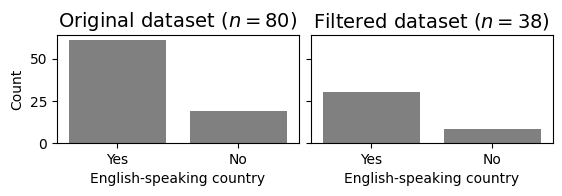

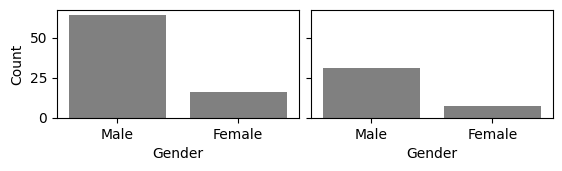

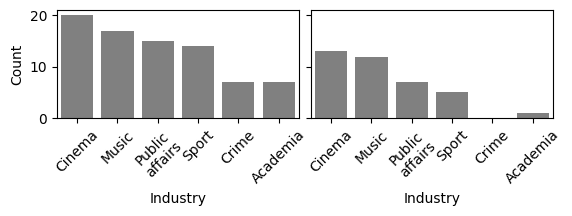

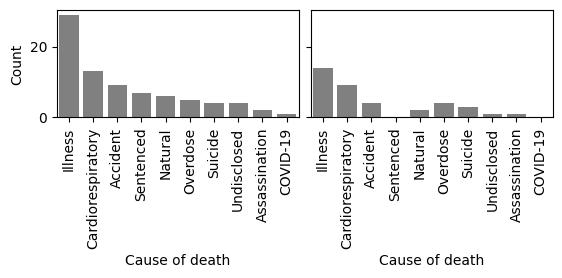

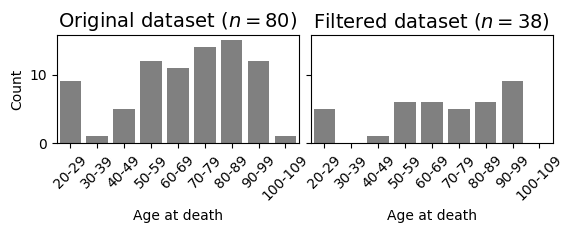

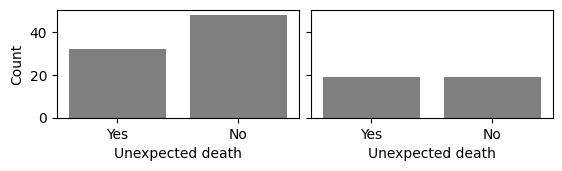

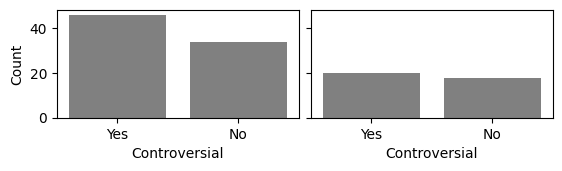

In [41]:
constrained_layout = False
wspace = .05

# English-speaking
x = 'english'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize_small, sharex=True, sharey=True, constrained_layout=constrained_layout)
fig.subplots_adjust(wspace=wspace)

order = binary_map.values()

sns.countplot(data=celeb, x=x, order=order, color='gray', ax=ax1)
ax1.set_xlabel('English-speaking country')

sns.countplot(data=celeb_filtered, x=x, order=order, color='gray', ax=ax2)
ax2.set_xlabel('English-speaking country')

ax1.set_ylabel('Count')
ax1.set_title(f'Original dataset ($n={len(celeb)}$)', size=14)
ax2.set_title(f'Filtered dataset ($n={len(celeb_filtered)}$)', size=14)

plt.savefig(f'plots/celeb_{x}.pdf', bbox_inches='tight', pad_inches=0)

# Gender
x = 'gender'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize_small, sharex=True, sharey=True, constrained_layout=constrained_layout)
fig.subplots_adjust(wspace=wspace)

order = celeb[x].value_counts().index

sns.countplot(data=celeb, x=x, order=order, color='gray', ax=ax1)
ax1.set_xlabel('Gender')

sns.countplot(data=celeb_filtered, x=x, order=order, color='gray', ax=ax2)
ax2.set_xlabel('Gender')

ax1.set_ylabel('Count')

plt.savefig(f'plots/celeb_{x}.pdf', bbox_inches='tight', pad_inches=0)

# Industry
x = 'industry'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize_small, sharex=True, sharey=True, constrained_layout=constrained_layout)
fig.subplots_adjust(wspace=wspace)

order = celeb[x].value_counts().index

sns.countplot(data=celeb, x=x, order=order, color='gray', ax=ax1)
ax1.tick_params('x', rotation=45)
ax1.set_xlabel('Industry')

sns.countplot(data=celeb_filtered, x=x, order=order, color='gray', ax=ax2)
ax2.tick_params('x', rotation=45)
ax2.set_xlabel('Industry')

ax1.set_ylabel('Count')
ax1.set_xticks(range(len(order)), labels=order.str.replace(' ', '\n'))

plt.savefig(f'plots/celeb_{x}.pdf', bbox_inches='tight', pad_inches=0)

# Cause of death
x = 'cause'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize_small, sharex=True, sharey=True, constrained_layout=constrained_layout)
fig.subplots_adjust(wspace=wspace)

order = celeb[x].value_counts().index

sns.countplot(data=celeb, x=x, order=order, color='gray', ax=ax1)
ax1.tick_params('x', rotation=90)
ax1.set_xlabel('Cause of death')

sns.countplot(data=celeb_filtered, x=x, order=order, color='gray', ax=ax2)
ax2.tick_params('x', rotation=90)
ax2.set_xlabel('Cause of death')

ax1.set_ylabel('Count')

plt.savefig(f'plots/celeb_{x}.pdf', bbox_inches='tight', pad_inches=0)

# Age at death
x = 'age'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize_small, sharex=True, sharey=True, constrained_layout=constrained_layout)
fig.subplots_adjust(wspace=wspace)

order = celeb[x].value_counts(sort=False).index

sns.countplot(data=celeb, x=x, order=order, color='gray', ax=ax1)
ax1.tick_params('x', rotation=45)
ax1.set_xlabel('Age at death')

sns.countplot(data=celeb_filtered, x=x, order=order, color='gray', ax=ax2)
ax2.tick_params('x', rotation=45)
ax2.set_xlabel('Age at death')

ax1.set_ylabel('Count')
ax1.set_title(f'Original dataset ($n={len(celeb)}$)', size=14)
ax2.set_title(f'Filtered dataset ($n={len(celeb_filtered)}$)', size=14)

plt.savefig(f'plots/celeb_{x}.pdf', bbox_inches='tight', pad_inches=0)

# Unexpected death
x = 'unexpected'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize_small, sharex=True, sharey=True, constrained_layout=constrained_layout)
fig.subplots_adjust(wspace=wspace)

order = binary_map.values()

sns.countplot(data=celeb, x=x, order=order, color='gray', ax=ax1)
ax1.set_xlabel('Unexpected death')

sns.countplot(data=celeb_filtered, x=x, order=order, color='gray', ax=ax2)
ax2.set_xlabel('Unexpected death')

ax1.set_ylabel('Count')

plt.savefig(f'plots/celeb_{x}.pdf', bbox_inches='tight', pad_inches=0)

# Controversial
x = 'controversial'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize_small, sharex=True, sharey=True, constrained_layout=constrained_layout)
fig.subplots_adjust(wspace=wspace)

order = binary_map.values()

sns.countplot(data=celeb, x=x, order=order, color='gray', ax=ax1)
ax1.set_xlabel('Controversial')

sns.countplot(data=celeb_filtered, x=x, order=order, color='gray', ax=ax2)
ax2.set_xlabel('Controversial')

ax1.set_ylabel('Count')

plt.savefig(f'plots/celeb_{x}.pdf', bbox_inches='tight', pad_inches=0)

Text(0.5, 1.0, 'Filtered dataset ($n=38$)')

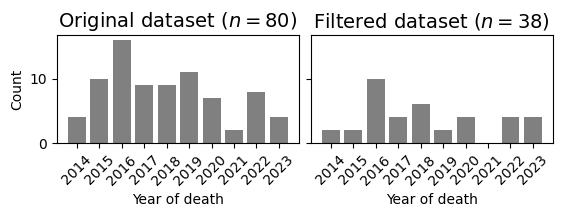

In [40]:
# Death date
x = 'death'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize_small, sharex=True, sharey=True, constrained_layout=constrained_layout)
fig.subplots_adjust(wspace=wspace)

celeb_yearly_counts = celeb[x].dt.year.value_counts().sort_index()
celeb_filtered_yearly_counts = celeb_filtered[x].dt.year.value_counts().sort_index()

ax1.bar(celeb_yearly_counts.index, celeb_yearly_counts, color='gray')
ax1.tick_params('x', rotation=45)
ax1.set_xlabel('Year of death')

ax2.bar(celeb_filtered_yearly_counts.index, celeb_filtered_yearly_counts, color='gray')
ax2.tick_params('x', rotation=45)
ax2.set_xlabel('Year of death')

ax1.set_ylabel('Count')
ax1.set_xticks(range(celeb_yearly_counts.index.min(), celeb_yearly_counts.index.max() + 1), labels=celeb_yearly_counts.index)
ax1.set_title(f'Original dataset ($n={len(celeb)}$)', size=14)
ax2.set_title(f'Filtered dataset ($n={len(celeb_filtered)}$)', size=14)

# plt.savefig(f'plots/celeb_{x}.pdf', bbox_inches='tight', pad_inches=0)

In [37]:
celeb['filtered'] = celeb.index.map(lambda x: binary_map[x in celeb_filter])
celeb['filtered']

name
XXXTentacion       Yes
Lil Peep            No
Juice Wrld         Yes
Anthoine Hubert     No
Dwayne Haskins     Yes
                  ... 
Jiang Zemin         No
Elizabeth II       Yes
Doris Day          Yes
Carol Channing      No
Manohar Aich        No
Name: filtered, Length: 80, dtype: object

In [38]:
celeb_cleaned = celeb_filtered[['english', 'gender', 'industry', 'cause', 'age', 'unexpected', 'controversial']].sort_index()
celeb_cleaned[:26].to_csv('tables/celebrities_cleaned1.csv')
celeb_cleaned[26:].to_csv('tables/celebrities_cleaned2.csv')

### Articles

In [39]:
articles = articles[articles['name'].isin(celeb_filter)].copy()

In [40]:
def split_pre_post_death(articles: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    pre_death = articles[articles['Period'] == 'Pre-death']
    post_death = articles[articles['Period'] == 'Post-death']
    return pre_death, post_death

In [41]:
# splitting into pre-death and post-death
pre_death, post_death = split_pre_post_death(articles)
len(pre_death), len(post_death)

(12283, 13762)

In [117]:
# dates of first and last article for each period
pre_dates = pre_death.groupby('name').agg({'datetime': ['min', 'max']}).rename(columns={'min': 'pre_first_art', 'max': 'pre_last_art'})
pre_dates.columns = pre_dates.columns.droplevel(0)
pre_dates['pre_first_art'] = pre_dates['pre_first_art'].dt.date
pre_dates['pre_last_art'] = pre_dates['pre_last_art'].dt.date

post_dates = post_death.groupby('name').agg({'datetime': ['min', 'max']}).rename(columns={'min': 'post_first_art', 'max': 'post_last_art'})
post_dates.columns = post_dates.columns.droplevel(0)
post_dates['post_first_art'] = post_dates['post_first_art'].dt.date
post_dates['post_last_art'] = post_dates['post_last_art'].dt.date

dates = pd.concat([pre_dates, post_dates], axis=1)
dates.head()

,pre_first_art,pre_last_art,post_first_art,post_last_art
name,,,,
Alan Rickman,2015-03-26,2015-12-18,2017-01-01,2017-12-23
Alan Thicke,2014-01-03,2014-12-09,2017-01-13,2017-12-14
Avicii,2014-01-17,2014-12-22,2019-04-06,2019-12-28
Carrie Fisher,2015-02-06,2016-01-03,2017-03-16,2018-06-27
Chris Cornell,2015-01-18,2015-12-22,2018-02-21,2018-12-07


In [43]:
# select top 100 articles by relevance for both periods
pre_death = pre_death.groupby('name').apply(lambda x: x.nlargest(100, 'relevance'), include_groups=False).reset_index().drop('level_1', axis=1)
post_death = post_death.groupby('name').apply(lambda x: x.nlargest(100, 'relevance'), include_groups=False).reset_index().drop('level_1', axis=1)
articles = pd.concat([pre_death, post_death], ignore_index=True)
articles.to_csv('data/articles_final.csv', index=False)

In [44]:
def mode(x: pd.Series):
    return x.mode()[0]

eda_stats = ['mean', 'median', mode, 'std', 'var', 'skew', 'count']

sentiment_eda = articles.groupby('Period')['sentiment'].agg(eda_stats)
sentiment_eda = sentiment_eda.sort_index(ascending=False)
sentiment_eda = sentiment_eda.round(4)
sentiment_eda.to_csv('tables/sentiment_eda.csv')
sentiment_eda

,mean,median,mode,std,var,skew,count
Period,,,,,,,
Pre-death,-0.0471,-0.0118,0.1216,0.3167,0.1003,-0.0955,3800
Post-death,0.0435,0.0667,0.0980,0.2570,0.0660,-0.2393,3800


In [45]:
sentiment_eda_agg = pd.DataFrame(articles['sentiment'].agg(eda_stats)).T
sentiment_eda_agg = sentiment_eda_agg.round(4)
sentiment_eda_agg.index = ['Total']
sentiment_eda_final = pd.concat([sentiment_eda, sentiment_eda_agg])
sentiment_eda_final['count'] = sentiment_eda_final['count'].astype(int)
sentiment_eda_final.index.name = 'Period'
sentiment_eda_final

,mean,median,mode,std,var,skew,count
Period,,,,,,,
Pre-death,-0.0471,-0.0118,0.1216,0.3167,0.1003,-0.0955,3800
Post-death,0.0435,0.0667,0.0980,0.2570,0.0660,-0.2393,3800
Total,-0.0018,0.0275,0.1216,0.2919,0.0852,-0.2362,7600


In [46]:
articles.groupby(['name', 'Period'])['sentiment'].agg(eda_stats)

mean    median      mode       std       var  \
name            Period                                                         
Alan Rickman    Post-death  0.147529  0.168627  0.145098  0.175960  0.030962   
                Pre-death  -0.246039 -0.337255 -0.403922  0.316792  0.100357   
Alan Thicke     Post-death -0.049176 -0.066667 -0.176471  0.218581  0.047778   
                Pre-death  -0.338275 -0.427451 -0.466667  0.264260  0.069833   
Avicii          Post-death  0.117647  0.129412 -0.027451  0.194708  0.037911   
...                              ...       ...       ...       ...       ...   
Stan Lee        Pre-death   0.080157  0.058824 -0.011765  0.213555  0.045606   
Stephen Hawking Post-death  0.133725  0.105882  0.105882  0.214592  0.046050   
                Pre-death  -0.106745 -0.094118 -0.074510  0.334590  0.111951   
XXXTentacion    Post-death -0.117333 -0.137255 -0.254902  0.200037  0.040015   
                Pre-death  -0.230275 -0.239216 -0.623529  0.264808  0.070123   

                                skew  count  
name            Period                       
Alan Rickman    Post-death -0.553124    100  
                Pre-death   0.811482    100  
Alan Thicke     Post-death  0.461488    100  
                Pre-death   1.374237    100  
Avicii          Post-death -0.343625    100  
...                              ...    ...  
Stan Lee        Pre-death   0.516745    100  
Stephen Hawking Post-death  0.644500    100  
                Pre-death   0.464435    100  
XXXTentacion    Post-death  0.057273    100  
                Pre-death   0.624255    100  

[76 rows x 7 columns]

In [47]:
PALETTE = ['b', 'r']
ALPHA = .75

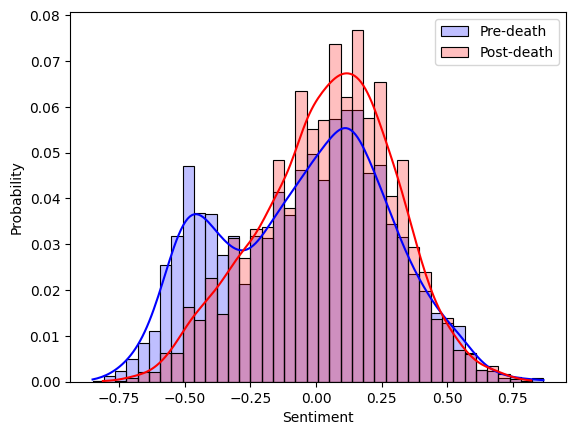

In [48]:
def plot_densities(pre_death: pd.DataFrame,
                   post_death: pd.DataFrame,
                   x: str = 'sentiment',
                   bins: int = 40,
                   kde: bool = True,
                   xlabel: str = 'Sentiment',
                   ax: plt.axes = None,
                   fig_name: str | None = None):

    pre_death = pre_death.dropna(subset=x)
    post_death = post_death.dropna(subset=x)

    bin_edges = np.histogram_bin_edges(np.concatenate((pre_death[x], post_death[x])), bins=bins)

    alpha=.25
    if not ax:
        fig, ax = plt.subplots()
    sns.histplot(data=pre_death, x=x, stat='probability', bins=bin_edges,
                 kde=kde, color=PALETTE[0], alpha=alpha, label='Pre-death',
                 ax=ax)
    sns.histplot(data=post_death, x=x, stat='probability', bins=bin_edges,
                 kde=kde, color=PALETTE[1], alpha=alpha, label='Post-death',
                 ax=ax)
    ax.set_xlabel(xlabel)
    ax.legend()

    if fig_name:
        plt.savefig(f'plots/{fig_name}.pdf', bbox_inches='tight', pad_inches=0)


plot_densities(pre_death, post_death, fig_name='pre_post_agg')

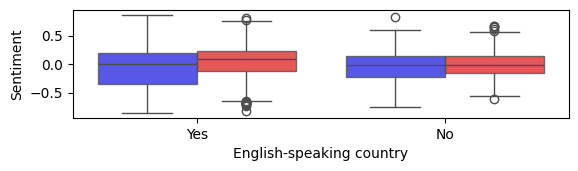

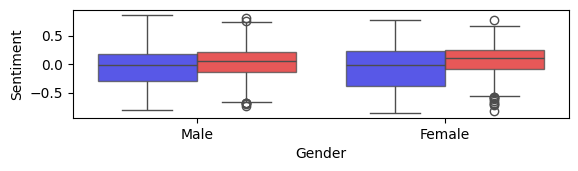

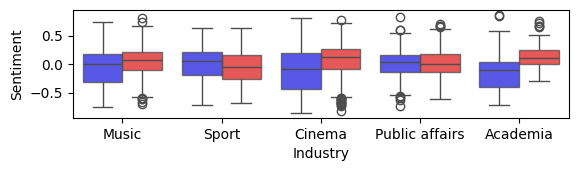

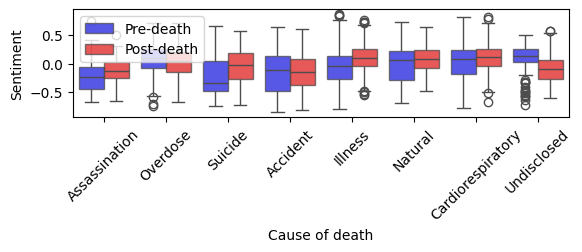

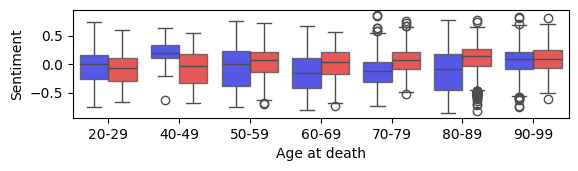

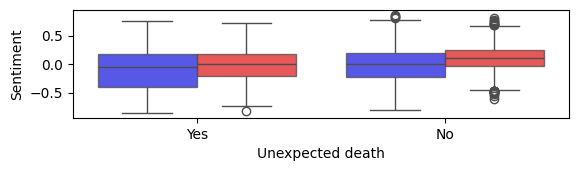

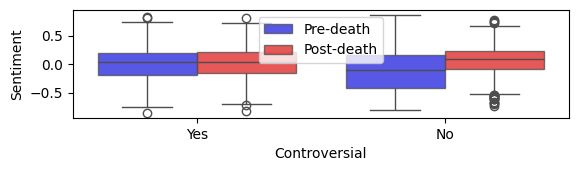

In [49]:
articles_merged = articles.merge(celeb_filtered, left_on='name', right_index=True)
articles_merged = articles_merged.sort_values('age')
articles_merged.columns = articles_merged.columns.str.capitalize()

constrained_layout = False

# Country
fig, ax = plt.subplots(figsize=figsize_small, constrained_layout=constrained_layout)
sns.boxplot(x='English', y='Sentiment', hue='Period', data=articles_merged, palette=PALETTE, ax=ax, boxprops={'alpha': ALPHA})
ax.set_xlabel('English-speaking country')
ax.legend([], frameon=False)
plt.savefig('plots/art_english.pdf', bbox_inches='tight', pad_inches=0)

# Gender
fig, ax = plt.subplots(figsize=figsize_small, constrained_layout=constrained_layout)
sns.boxplot(x='Gender', y='Sentiment', hue='Period', data=articles_merged, palette=PALETTE, ax=ax, boxprops={'alpha': ALPHA})
ax.legend([], frameon=False)
plt.savefig('plots/art_gender.pdf', bbox_inches='tight', pad_inches=0)

# Industry
fig, ax = plt.subplots(figsize=figsize_small, constrained_layout=constrained_layout)
sns.boxplot(x='Industry', y='Sentiment', hue='Period', data=articles_merged, palette=PALETTE, ax=ax, boxprops={'alpha': ALPHA})
ax.legend([], frameon=False)
plt.savefig('plots/art_industry.pdf', bbox_inches='tight', pad_inches=0)

# Cause of death
fig, ax = plt.subplots(figsize=figsize_small, constrained_layout=constrained_layout)
sns.boxplot(x='Cause', y='Sentiment', hue='Period', data=articles_merged, palette=PALETTE, ax=ax, boxprops={'alpha': ALPHA})
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel('Cause of death')
ax.legend(title='')
plt.savefig('plots/art_cause.pdf', bbox_inches='tight', pad_inches=0)

# Age at death
fig, ax = plt.subplots(figsize=figsize_small, constrained_layout=constrained_layout)
sns.boxplot(x='Age', y='Sentiment', hue='Period', data=articles_merged, palette=PALETTE, ax=ax, boxprops={'alpha': ALPHA})
ax.set_xlabel('Age at death')
ax.legend([], frameon=False)
plt.savefig('plots/art_age.pdf', bbox_inches='tight', pad_inches=0)

# Unexpected
fig, ax = plt.subplots(figsize=figsize_small, constrained_layout=constrained_layout)
sns.boxplot(x='Unexpected', y='Sentiment', hue='Period', data=articles_merged, palette=PALETTE, ax=ax, boxprops={'alpha': ALPHA})
ax.set_xlabel('Unexpected death')
ax.legend([], frameon=False)
plt.savefig('plots/art_unexpected.pdf', bbox_inches='tight', pad_inches=0)

# Controversial
fig, ax = plt.subplots(figsize=figsize_small, constrained_layout=constrained_layout)
sns.boxplot(x='Controversial', y='Sentiment', hue='Period', data=articles_merged, palette=PALETTE, ax=ax, boxprops={'alpha': ALPHA})
ax.legend(title='')
plt.savefig('plots/art_controversial.pdf', bbox_inches='tight', pad_inches=0)

In [50]:
celeb['industry'].value_counts()

industry
Cinema            20
Music             17
Public affairs    15
Sport             14
Crime              7
Academia           7
Name: count, dtype: int64

In [51]:
celeb_filtered['industry'].value_counts()

industry
Cinema            13
Music             12
Public affairs     7
Sport              5
Academia           1
Name: count, dtype: int64

### Article sources

#### Source URL

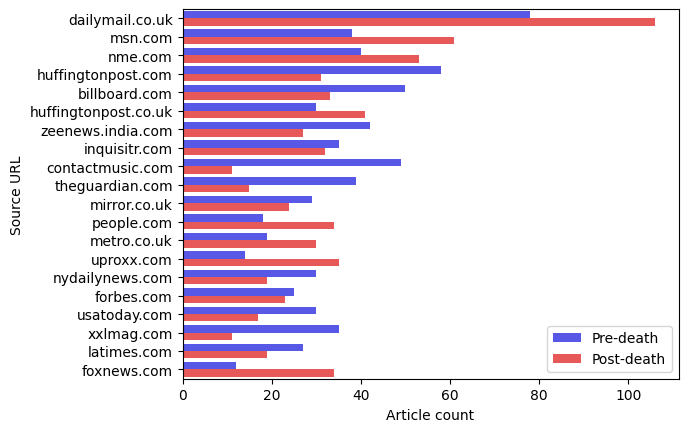

In [52]:
uri_counts = articles['source_uri'].value_counts()
top_uris = uri_counts[:20].index

fix, ax = plt.subplots()
sns.countplot(data=articles[articles['source_uri'].isin(top_uris)],
              y='source_uri', hue='Period', order=top_uris,
              palette=PALETTE, alpha=ALPHA, ax=ax)
ax.set_xlabel('Article count')
ax.set_ylabel('Source URL')
ax.legend(title='')

plt.savefig('plots/source_uris.pdf', bbox_inches='tight', pad_inches=0)

In [53]:
len(uri_counts[uri_counts < 10]) / len(uri_counts)

0.9085331846068042

In [54]:
len(uri_counts[uri_counts == 1]) / len(uri_counts)

0.4986056887897379

#### Source country

In [55]:
print(f'Articles without location: {articles['source_loc'].isna().sum()}/{len(articles)}')

Articles without location: 360/7600


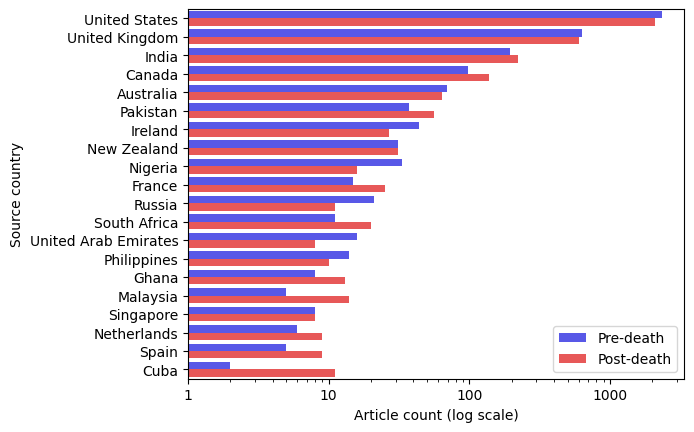

In [56]:
with open('data/loc_country.json', 'r') as f: 
    loc_country_dict = json.load(f)

articles['Source country'] = articles['source_loc'].map(loc_country_dict)

country_counts = articles['Source country'].value_counts()
top_countries = country_counts[:20].index

fix, ax = plt.subplots()
sns.countplot(data=articles[articles['Source country'].isin(top_countries)],
              y='Source country', hue='Period', order=top_countries,
              palette=PALETTE, alpha=ALPHA, ax=ax)
ax.set_xscale('log')
xticks = [1, 10, 100, 1000]
ax.set_xticks(xticks, labels=xticks)
ax.set_xlabel('Article count (log scale)')
ax.legend(title='')

plt.savefig('plots/source_countries.pdf', bbox_inches='tight', pad_inches=0)

source_uri
pre unique count: 1171/1793
post unique count: 1149/1793
SignificanceResult(statistic=0.5356143712530118, pvalue=1.842989815337419e-40)
df = 1791

Source country
pre unique count: 68/86
post unique count: 64/86
SignificanceResult(statistic=0.7947675660381558, pvalue=4.2633427466996195e-11)
df = 84



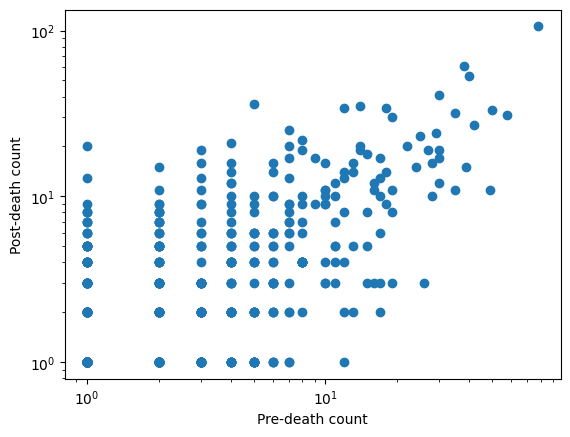

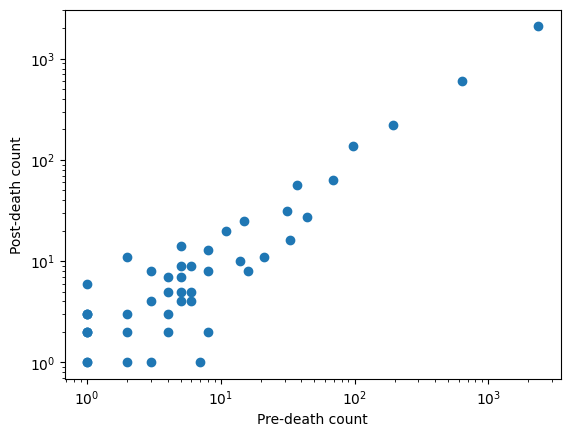

In [57]:
pre_death, post_death = split_pre_post_death(articles)

for col in ['source_uri', 'Source country']:
    pre_source_counts = pre_death[col].value_counts().reset_index().rename(columns={'count': 'pre_count'})
    post_source_counts = post_death[col].value_counts().reset_index().rename(columns={'count': 'post_count'})
    source_counts = pre_source_counts.merge(post_source_counts, how='outer').fillna(0)
    print(col)
    print(f'pre unique count: {len(pre_source_counts)}/{len(source_counts)}')
    print(f'post unique count: {len(post_source_counts)}/{len(source_counts)}')
    print(stats.spearmanr(source_counts.loc[(source_counts['pre_count'] > 0) & (source_counts['post_count'] > 0), 'pre_count'], source_counts.loc[(source_counts['pre_count'] > 0) & (source_counts['post_count'] > 0), 'post_count']))
    print('df =', len(source_counts) - 2)
    print()

    fig, ax = plt.subplots()
    ax.scatter(source_counts['pre_count'], source_counts['post_count'])
    ax.set_xlabel('Pre-death count')
    ax.set_ylabel('Post-death count')
    ax.set_xscale('log')
    ax.set_yscale('log')

#### Source rank

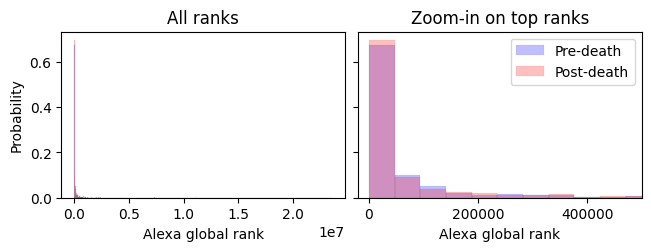

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(FIGSIZE[0], FIGSIZE[1] / 2), sharey=True, constrained_layout=True)
plot_densities(pre_death,
               post_death,
               x='source_alexa_global_rank', xlabel='Alexa global rank',
               kde=False, bins=500, ax=ax1)
plot_densities(pre_death,
               post_death,
               x='source_alexa_global_rank', xlabel='Alexa global rank',
               kde=False, bins=500, ax=ax2)
ax1.set_title('All ranks')
ax1.legend([], frameon=False)
ax2.set_xlim(-20000, 500000)
ax2.set_xticks([0, 200000, 400000])
ax2.set_title('Zoom-in on top ranks')
ax2.set_ylabel('')

plt.savefig('plots/source_ranks.pdf', bbox_inches='tight', pad_inches=0)

In [59]:
def rank_biserial_r(x, y, U1):
    """Calculate effect size using rank biserial correlation coefficient r."""
    n1, n2 = len(x), len(y)
    return 2 * U1 / (n1 * n2) - 1

def get_U2(x, y, U1):
    """Calculate the U2 statistic."""
    n1, n2 = len(x), len(y)
    return n1 * n2 - U1

In [60]:
U1, pval = stats.mannwhitneyu(pre_death.loc[pre_death['source_alexa_global_rank'].notna(), 'source_alexa_global_rank'],
                              post_death.loc[post_death['source_alexa_global_rank'].notna(), 'source_alexa_global_rank'])
U1, pval

(6929383.5, 0.059306746397645084)

In [61]:
rank_biserial_r(pre_death['source_alexa_global_rank'], post_death['source_alexa_global_rank'], U1)

-0.0402515927977839

## RQ1

### Aggregate test

In [62]:
alternative = 'two-sided'
alternative = 'less'

In [63]:
def bootstrap_ci(data, z=stats.norm.ppf(.975)):
    "Returns bootstrap estimate and confidence interval."
    theta_hat = np.mean(data)
    se = np.std(data)
    ci = np.array([theta_hat - z * se, theta_hat + z * se])
    return theta_hat, ci


def bootstrap(pre_sent, post_sent, alternative='less', B=1000, seed=42):
    # Bootstrap the data
    boot_stats = np.zeros(B)
    boot_pvals = np.zeros(B)
    boot_rs = np.zeros(B)

    np.random.seed(seed)
    for i in range(B):
        # Resample with replacement
        pre_sample = np.random.choice(pre_sent, size=len(pre_sent), replace=True)
        post_sample = np.random.choice(post_sent, size=len(post_sent), replace=True)
        
        # Perform Mann-Whitney U test on resampled data
        boot_U1, boot_pval = stats.mannwhitneyu(pre_sample, post_sample, alternative=alternative)
        boot_r = rank_biserial_r(pre_sample, post_sample, boot_U1)
        boot_stats[i] = boot_U1
        boot_pvals[i] = boot_pval
        boot_rs[i] = boot_r

    return boot_stats, boot_pvals, boot_rs

Bootstrap U1-statistic: 6044570.70 (95% CI [5862990.21 6226151.18])
Bootstrap p-value: 1.783697987222194e-24 (95% CI [-9.18834195e-23  9.54508154e-23])
Bootstrap r: -0.16 (95% CI [-0.19 -0.14])


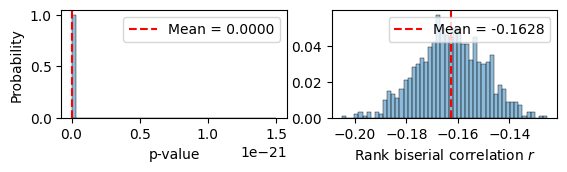

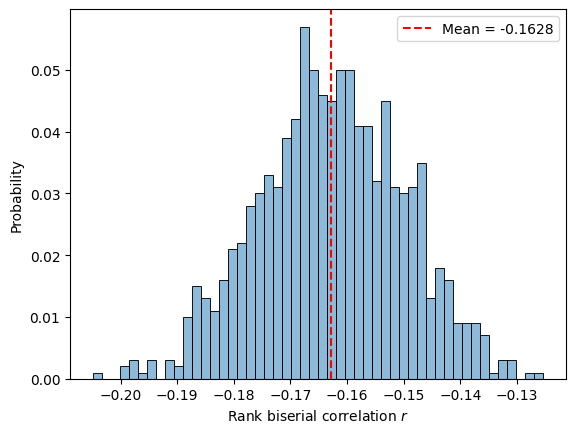

In [64]:
pre_sent = pre_death['sentiment']
post_sent = post_death['sentiment']

# Bootstrap the data
boot_stats, boot_pvals, boot_rs = bootstrap(pre_sent, post_sent, alternative=alternative)

# Analyze the bootstrap results
stat_mean, stat_ci = bootstrap_ci(boot_stats)
print(f'Bootstrap U1-statistic: {stat_mean:.2f} (95% CI {np.round(stat_ci, 2)})')

pval_mean, pval_ci = bootstrap_ci(boot_pvals)
print(f'Bootstrap p-value: {pval_mean} (95% CI {pval_ci})')

r_mean, r_ci = bootstrap_ci(boot_rs)
print(f'Bootstrap r: {r_mean:.2f} (95% CI {np.round(r_ci, 2)})')

mwu_agg_dict = {
    'u_stat': stat_mean,
    'u_stat_ci': stat_ci,
    'pval': pval_mean,
    'pval_ci': pval_ci,
    'r': r_mean,
    'r_ci': r_ci,
}

mwu_agg_df = pd.DataFrame([mwu_agg_dict], index=['ALL CELEBRITIES'])

# Plot the bootstrap distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize_small)

sns.histplot(boot_pvals, stat='probability', bins=50, ax=ax1, alpha=.5)
ax1.axvline(pval_mean, color='r', linestyle='--', label=f'Mean = {pval_mean:.4f}')
ax1.set_xlabel('p-value')
ax1.legend()

sns.histplot(boot_rs, stat='probability', bins=50, ax=ax2, alpha=.5)
ax2.axvline(r_mean, color='r', linestyle='--', label=f'Mean = {r_mean:.4f}')
ax2.set_xlabel('Rank biserial correlation $r$')
ax2.set_ylabel('')
ax2.legend()


# Plot the bootstrap distribution
fig, ax = plt.subplots()
sns.histplot(boot_rs, stat='probability', bins=50, ax=ax, alpha=.5)
ax.axvline(r_mean, color='r', linestyle='--', label=f'Mean = {r_mean:.4f}')
ax.set_xlabel('Rank biserial correlation $r$')
ax.legend()

plt.savefig('plots/bootstrap.pdf', bbox_inches='tight', pad_inches=0)

### Individual tests

In [65]:
mwu_tests_list = []

for name in celeb_filter:
    pre_sent = pre_death.loc[pre_death['name'] == name, 'sentiment']
    post_sent = post_death.loc[post_death['name'] == name, 'sentiment']
    
    # Bootstrap the data
    boot_stats, boot_pvals, boot_rs = bootstrap(pre_sent, post_sent, alternative=alternative)

    # Analyze the bootstrap results
    stat_mean, stat_ci = bootstrap_ci(boot_stats)
    pval_mean, pval_ci = bootstrap_ci(boot_pvals)
    r_mean, r_ci = bootstrap_ci(boot_rs)
    
    mwu_tests_list.append({
        'u_stat': stat_mean,
        'u_stat_ci': stat_ci,
        'pval': pval_mean,
        'pval_ci': pval_ci,
        'r': r_mean,
        'r_ci': r_ci,
    })

mwu_tests = pd.DataFrame(mwu_tests_list, index=celeb_filter)
mwu_tests = mwu_tests.sort_values('r', ascending=False)
mwu_tests_final = pd.concat([mwu_agg_df, mwu_tests])
mwu_tests_final = mwu_tests_final.round(4)
mwu_tests_final['r_ci'] = mwu_tests_final['r_ci'].apply(lambda x: np.round(x, 4))
mwu_tests_final[['u_stat', 'pval', 'r', 'r_ci']].iloc[::-1].to_csv(f'tables/mwu_{alternative}.csv', index_label='name')
mwu_tests_final.head()

,u_stat,u_stat_ci,pval,pval_ci,r,r_ci
ALL CELEBRITIES,6.044571e+06,"[5862990.211127621, 6226151.1788723795]",0.0,"[-9.188341947531591e-23, 9.545081544976029e-23]",-0.1628,"[-0.188, -0.1377]"
Dwayne Haskins,8.965952e+03,"[8491.536780216438, 9440.36821978356]",1.0,"[0.9999999999999996, 1.0000000000000004]",0.7932,"[0.6983, 0.8881]"
Mac Miller,7.884935e+03,"[7260.61539696847, 8509.25460303153]",1.0,"[0.9999992871119601, 1.0000006794658245]",0.5770,"[0.4521, 0.7019]"
Kobe Bryant,7.624322e+03,"[6951.962291541372, 8296.680708458629]",1.0,"[0.9999778346331166, 1.0000209717485886]",0.5249,"[0.3904, 0.6593]"
Diego Maradona,7.468171e+03,"[6811.344438289171, 8124.997561710829]",1.0,"[0.9999136816045092, 1.000081280287722]",0.4936,"[0.3623, 0.625]"


In [66]:
# u_tests = u_tests.merge(celeb_filtered['industry'], left_index=True, right_index=True)
# u_tests['y'] = u_tests.index + ' - ' + u_tests['industry']

In [67]:
figsize_big = (FIGSIZE[0], 9)

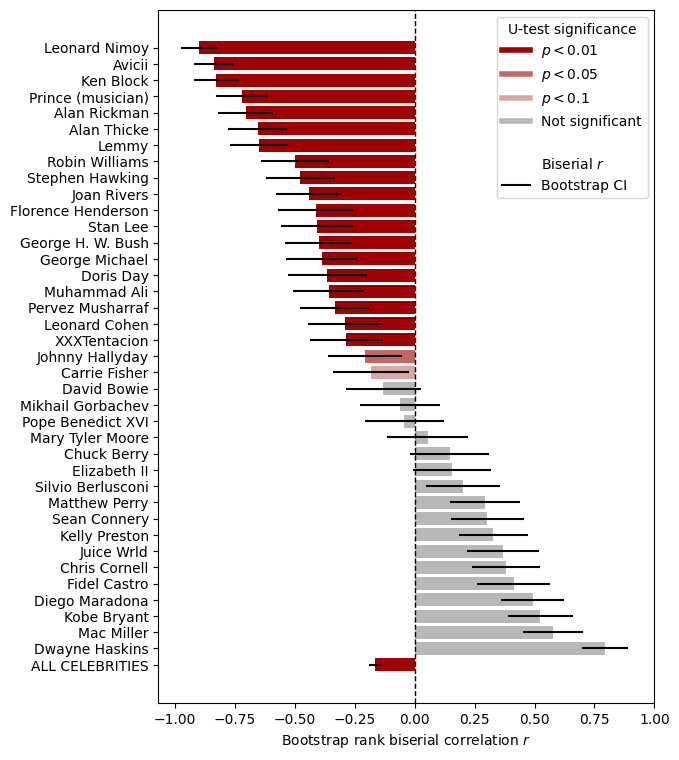

In [68]:
def set_color(pval):
    if pval < .01:
        return palette[0]
    elif pval < .05:
        return palette[1]
    elif pval < .1:
        return palette[2]
    else:
        return palette[3]


palette = ['#1f6f6f', '#54a1a1', '#9fc8c8', '#b8b8b8']
palette = ['#2066a8', '#3594cc', '#8cc5e3', '#b8b8b8']
palette = ['#a00000', '#c46666', '#d8a6a6', '#b8b8b8']
alpha = 1

mwu_tests_final['xerr'] = mwu_tests_final['r_ci'].str[1] - mwu_tests_final['r']
mwu_tests_final['color'] = mwu_tests_final['pval'].apply(set_color)

fig, ax = plt.subplots(figsize=figsize_big)
# fig, ax = plt.subplots(figsize=(4.75, 9))
# ax.barh(u_tests['y'], u_tests['r'], color=u_tests['color'], alpha=alpha, xerr=u_tests['xerr'])

ax.barh(mwu_tests_final.index, mwu_tests_final['r'], color=mwu_tests_final['color'], alpha=alpha, xerr=mwu_tests_final['xerr'])
ax.axvline(0, linestyle='--', linewidth=1, color='k')
ax.set_xlabel('Bootstrap rank biserial correlation $r$')
ax.set_xticks(np.linspace(-1, 1, 9))

# Add a legend
from matplotlib.lines import Line2D

handles = [
    # Line2D([], [], color='none', lw=1.5, label='U-test significance'),
    Line2D([], [], color=palette[0], lw=4, alpha=alpha, label='$p<0.01$'),
    Line2D([], [], color=palette[1], lw=4, alpha=alpha, label='$p<0.05$'),
    Line2D([], [], color=palette[2], lw=4, alpha=alpha, label='$p<0.1$'),
    Line2D([], [], color=palette[3], lw=4, alpha=alpha, label='Not significant'),
    Line2D([], [], color='none'),
    Line2D([], [], color='none', label='Biserial $r$'),
    Line2D([], [], color='k', lw=1.5, label='Bootstrap CI')
]
ax.legend(handles=handles, loc='upper right', title='U-test significance')

plt.savefig(f'plots/effect_size_{alternative}.pdf', bbox_inches='tight', pad_inches=0)

In [69]:
print(f'Reject null: {len(mwu_tests[mwu_tests['pval'] < .1])}/{len(celeb_filter)}')
print()
print(f'Large effect: {len(mwu_tests[mwu_tests['r'] <= -.5])}/{len(celeb_filter)}')
print(f'Medium effect: {len(mwu_tests[(mwu_tests['r'] <= -.3) & (mwu_tests['r'] > -.5)])}/{len(celeb_filter)}')
print(f'Small effect: {len(mwu_tests[(mwu_tests['r'] <= -.1) & (mwu_tests['r'] > -.3)])}/{len(celeb_filter)}')

Reject null: 21/38

Large effect: 7/38
Medium effect: 10/38
Small effect: 5/38


## RQ2

In [70]:
features = ['english', 'gender', 'industry', 'cause', 'age', 'unexpected', 'controversial']
size = 100
paired_articles = pd.concat([celeb_filtered[features]] * size, ignore_index=False).reset_index()

np.random.seed(42)
for name in celeb_filter:
    pre_sent = np.random.choice(pre_death.loc[pre_death['name'] == name, 'sentiment'], size=size, replace=False)
    post_sent = np.random.choice(post_death.loc[post_death['name'] == name, 'sentiment'], size=size, replace=False)
    diff = post_sent - pre_sent
    paired_articles.loc[paired_articles['name'] == name, 'diff'] = diff
paired_articles.head()

,name,english,gender,industry,cause,age,unexpected,controversial,diff
0,XXXTentacion,Yes,Male,Music,Assassination,20-29,Yes,Yes,0.196078
1,Juice Wrld,Yes,Male,Music,Overdose,20-29,Yes,Yes,-0.149020
2,Dwayne Haskins,Yes,Male,Sport,Accident,20-29,Yes,Yes,-0.180392
3,Mac Miller,Yes,Male,Music,Overdose,20-29,Yes,No,-0.219608
4,Avicii,No,Male,Music,Suicide,20-29,Yes,No,0.901961


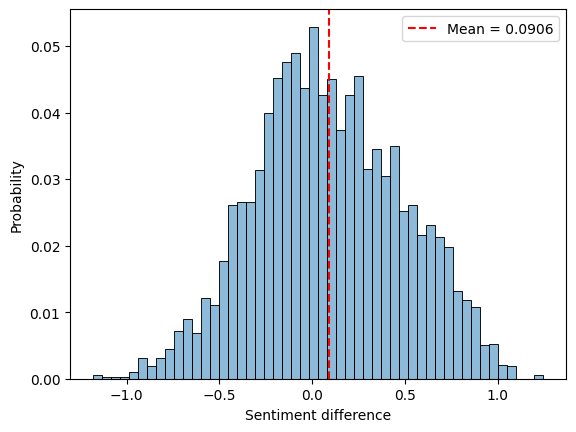

In [71]:
mean_diff = paired_articles['diff'].mean()
fig, ax = plt.subplots()
sns.histplot(data=paired_articles, x='diff', stat='probability', bins=50, alpha=.5)
ax.axvline(mean_diff, color='r', linestyle='--',label=f'Mean = {mean_diff:.4f}')
ax.set_xlabel('Sentiment difference')
ax.legend()

plt.savefig('plots/diff_dist.pdf', bbox_inches='tight', pad_inches=0)

In [72]:
group_means = pd.DataFrame()

for feature in features:
    stat = paired_articles.groupby(feature)['diff'].agg(['mean', 'std', 'var', 'count']).reset_index()
    
    stat['feature'] = feature
    stat = stat.rename({feature: 'group'}, axis=1)
    group_means = pd.concat([group_means, stat], ignore_index=True)

cols = group_means.columns.tolist()
cols = cols[-1:] + cols[:-1]
group_means = group_means[cols]
group_means = group_means.round(4)
group_means.to_csv('tables/group_means.csv', index=False)
group_means.head()

,feature,group,mean,std,var,count
0,english,No,0.0394,0.3694,0.1365,800
1,english,Yes,0.1043,0.4068,0.1655,3000
2,gender,Female,0.0987,0.4003,0.1602,700
3,gender,Male,0.0888,0.4001,0.1600,3100
4,industry,Academia,0.2405,0.3824,0.1463,100


### ANOVA

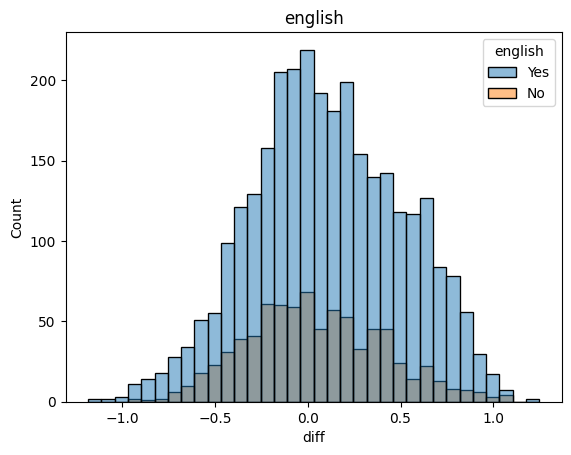

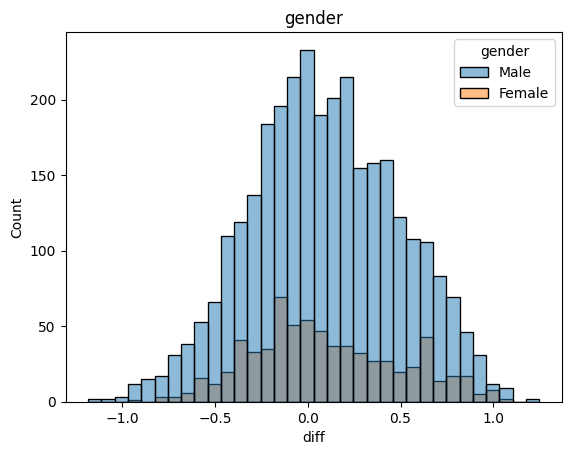

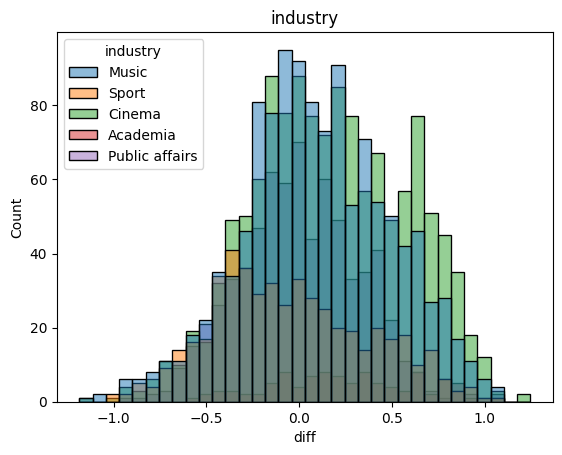

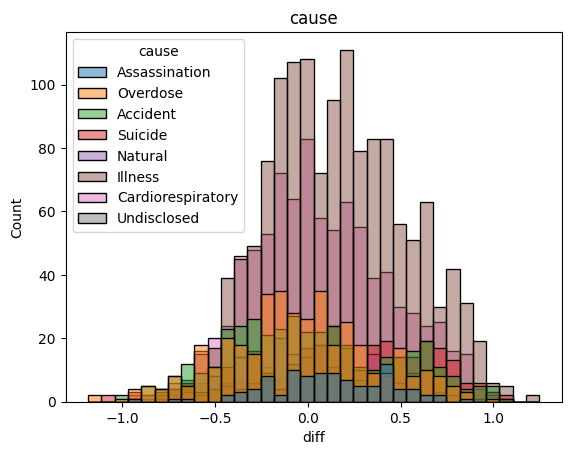

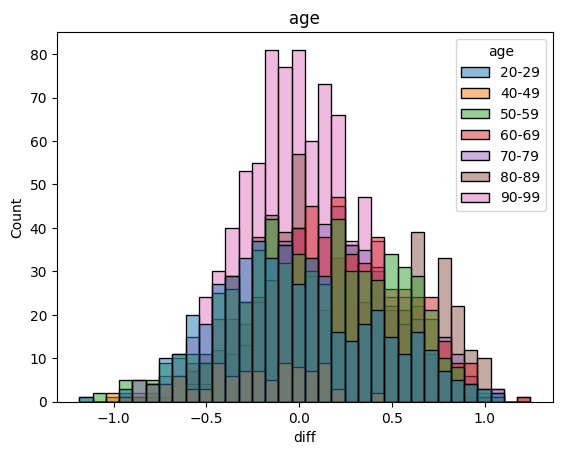

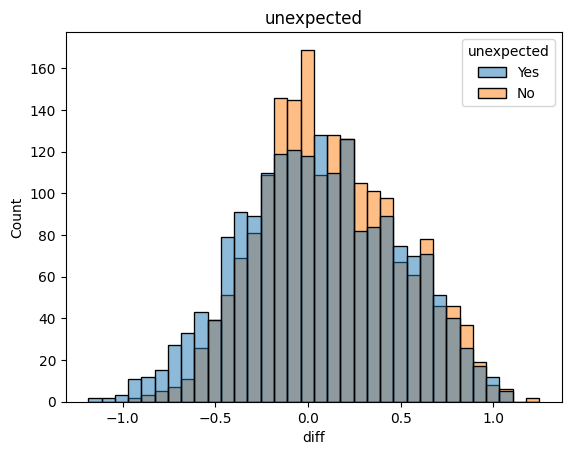

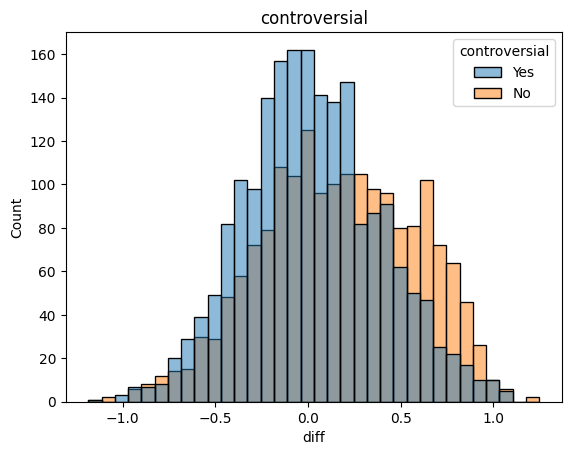

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

for feature in features:
    sns.histplot(data=paired_articles, x='diff', hue=feature)
    plt.title(feature)
    plt.show()

In [74]:
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd


# Perform ANOVA
model = ols(f'diff ~ {" + ".join(features)}', data=paired_articles).fit()
anova = sm.stats.anova_lm(model, typ=2)
anova['df'] = anova['df'].astype(int)

# Compute partial eta-squared
anova['partial_eta_squared'] = anova['sum_sq'] / (anova['sum_sq'] + anova.at['Residual', 'sum_sq'])
anova.at['Residual', 'partial_eta_squared'] = np.nan

# Compute omega-squared
anova['mean_sq'] = anova['sum_sq'] / anova['df']  # mean square for each effect
ms_error = anova.at['Residual', 'mean_sq']  # mean square error
anova['omega_squared'] = (anova['sum_sq'] - (anova['df'] * ms_error)) / (anova['sum_sq'].sum() + ms_error)
anova.at['Residual', 'omega_squared'] = np.nan


anova = anova.round(4)
anova = anova.fillna('-')
anova.to_csv('tables/anova.csv', index_label='feature')
anova

,sum_sq,df,F,PR(>F),partial_eta_squared,mean_sq,omega_squared
english,0.0066,1,0.0471,0.8281,0.0,0.0066,-0.0002
gender,5.6634,1,40.3958,0.0,0.0106,5.6634,0.0094
industry,8.3977,4,14.9748,0.0,0.0156,2.0994,0.0133
cause,20.6400,7,21.0317,0.0,0.0375,2.9486,0.0334
age,22.1909,6,26.3806,0.0,0.0402,3.6985,0.0363
unexpected,0.0180,1,0.1281,0.7204,0.0,0.0180,-0.0002
controversial,2.1439,1,15.2919,0.0001,0.004,2.1439,0.0034
Residual,529.6648,3778,-,-,-,0.1402,-


In [75]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


encoded = pd.get_dummies(paired_articles[features], drop_first=True).astype(int)

# Define dependent and independent variables
y = paired_articles['diff']
X = encoded

# Check for multicollinearity
vif_data = pd.DataFrame({
    'feature': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

vif_data.sort_values('VIF', ignore_index=True)

,feature,VIF
0,age_40-49,1.625891
1,cause_Assassination,1.895777
2,cause_Undisclosed,2.127233
3,cause_Natural,2.730803
4,age_50-59,3.198610
5,cause_Suicide,3.793105
6,cause_Overdose,3.948830
7,age_70-79,4.612798
8,industry_Sport,5.005244
9,age_60-69,5.700821


### Tukey's HSD

In [76]:
# Tukey's HSD test
tukey_features = ['industry', 'cause', 'age']

tukey_dict = {}
tukey_df = pd.DataFrame()

for feature in tukey_features:
    tukey = pairwise_tukeyhsd(endog=paired_articles['diff'], groups=paired_articles[feature])
    tukey_dict[feature] = tukey
    
    tukey_data = tukey.summary().data
    df = pd.DataFrame(data=tukey_data[1:], columns=tukey_data[0])
    df['feature'] = feature
    tukey_df = pd.concat([tukey_df, df], ignore_index=True)

# get confidence interval
tukey_df['ci'] = tukey_df[['lower', 'upper']].apply(lambda x: np.array(x), axis=1)

# reorder columns and drop unnecessary ones
tukey_df = tukey_df[['feature', 'group1', 'group2', 'meandiff', 'ci', 'p-adj']]

# save df as csv
tukey_df.iloc[:40].to_csv('tables/tukey_hsd1.csv', index=False)
tukey_df.iloc[40:].to_csv('tables/tukey_hsd2.csv', index=False)
tukey_df.head()

,feature,group1,group2,meandiff,ci,p-adj
0,industry,Academia,Cinema,-0.0719,"[-0.183, 0.0392]",0.3936
1,industry,Academia,Music,-0.1424,"[-0.2538, -0.0309]",0.0045
2,industry,Academia,Public affairs,-0.2334,"[-0.3479, -0.119]",0.0000
3,industry,Academia,Sport,-0.2833,"[-0.4006, -0.1661]",0.0000
4,industry,Cinema,Music,-0.0705,"[-0.1133, -0.0276]",0.0001


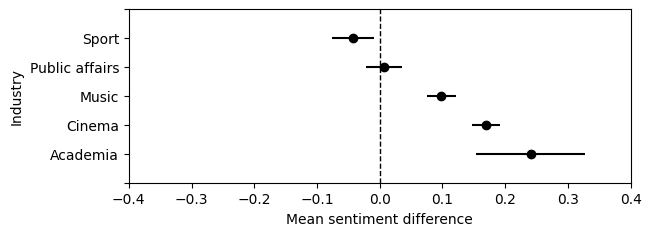

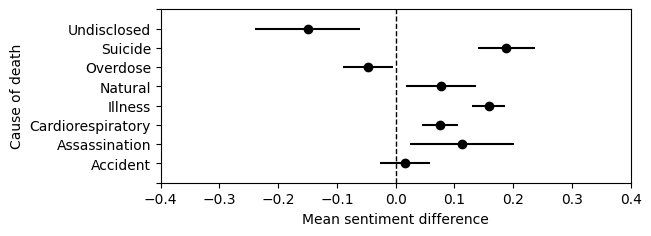

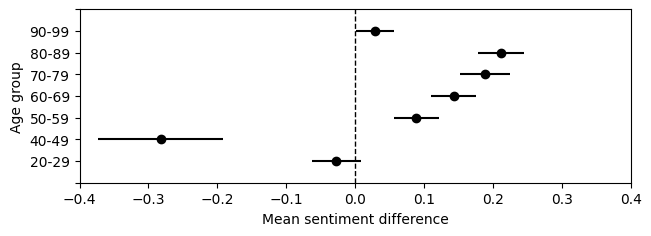

In [77]:
constrained_layout = True
figsize_hsd = (FIGSIZE[0], 2.25)
left, right = -.4, .4
xlabel = 'Mean sentiment difference'

# # Country
# x = 'english'
# tukey = tukey_dict[x]
# fig, ax = plt.subplots(constrained_layout=constrained_layout)
# tukey.plot_simultaneous(ax=ax, figsize=figsize_hsd, xlabel=xlabel, ylabel='English-speaking\ncountry')
# ax.axvline(0, color='k', ls='--', lw=1)
# ax.set_title('')
# ax.set_xlim(left, right)
# plt.savefig(f'plots/tukey_{x}.pdf', bbox_inches='tight', pad_inches=0)

# # Gender
# x = 'gender'
# tukey = tukey_dict[x]
# fig, ax = plt.subplots(constrained_layout=constrained_layout)
# tukey.plot_simultaneous(ax=ax, figsize=figsize_hsd, xlabel=xlabel, ylabel='Gender')
# ax.axvline(0, color='k', ls='--', lw=1)
# ax.set_title('')
# ax.set_yticks([0, 1], labels=['Male', 'Female'])
# ax.set_xlim(left, right)
# plt.savefig(f'plots/tukey_{x}.pdf', bbox_inches='tight', pad_inches=0)

# Industry
x = 'industry'
tukey = tukey_dict[x]
fig, ax = plt.subplots(constrained_layout=constrained_layout)
tukey.plot_simultaneous(ax=ax, figsize=figsize_hsd, xlabel=xlabel, ylabel='Industry')
ax.axvline(0, color='k', ls='--', lw=1)
ax.set_title('')
ax.set_xlim(left, right)
plt.savefig(f'plots/tukey_{x}.pdf', bbox_inches='tight', pad_inches=0)

# Cause of death
x = 'cause'
tukey = tukey_dict[x]
fig, ax = plt.subplots(constrained_layout=constrained_layout)
tukey.plot_simultaneous(ax=ax, figsize=figsize_hsd, xlabel=xlabel, ylabel='Cause of death')
ax.axvline(0, color='k', ls='--', lw=1)
ax.set_title('')
ax.set_xlim(left, right)
plt.savefig(f'plots/tukey_{x}.pdf', bbox_inches='tight', pad_inches=0)

# Age at death
x = 'age'
tukey = tukey_dict[x]
fig, ax = plt.subplots(constrained_layout=constrained_layout)
tukey.plot_simultaneous(ax=ax, figsize=figsize_hsd, xlabel=xlabel, ylabel='Age group')
ax.axvline(0, color='k', ls='--', lw=1)
ax.set_title('')
ax.set_xlim(left, right)
plt.savefig(f'plots/tukey_{x}.pdf', bbox_inches='tight', pad_inches=0)

# # Unexpected death
# x = 'unexpected'
# tukey = tukey_dict[x]
# fig, ax = plt.subplots(constrained_layout=constrained_layout)
# tukey.plot_simultaneous(ax=ax, figsize=figsize_hsd, xlabel=xlabel, ylabel='Unexpected death')
# ax.axvline(0, color='k', ls='--', lw=1)
# ax.set_title('')
# ax.set_xlim(left, right)
# plt.savefig(f'plots/tukey_{x}.pdf', bbox_inches='tight', pad_inches=0)

# # Controversial
# x = 'controversial'
# tukey = tukey_dict[x]
# fig, ax = plt.subplots(constrained_layout=constrained_layout)
# tukey.plot_simultaneous(ax=ax, figsize=figsize_hsd, xlabel=xlabel, ylabel='Controversial')
# ax.axvline(0, color='k', ls='--', lw=1)
# ax.set_title('')
# ax.set_xlim(left, right)
# plt.savefig(f'plots/tukey_{x}.pdf', bbox_inches='tight', pad_inches=0)

## RQ3

In [78]:
# # THE ONE THAT WORKS

# import re
# import nltk
# from nltk.corpus import stopwords
# from string import punctuation


# other_char_list = [
#     'æ', 'µ', '²', '¢', 'ὢ', 'õ', '±', 'ô', '¥', '»', 'ë', '×', '«', 'þ', 'ș',
#     'و', 'û', 'ñ', '¶', 'ì', 'ℏ', '³', 'á', 'à', 'ὁ', 'å', 'ἰ', 'ç', 'س', 'ć',
#     'ó', 'â', '¸', 'î', '¼', '£', 'º', '¦', 'ú', 'ä', '¾', 'è', 'ï', 'ö', '´',
#     '희', '½', 'ß', 'ù', 'ª', 'č', '¡', 'é', '¤', 'ø', 'أ', 'í', 'ἷ', '÷', '°',
#     '¨', '¬', '®', 'ὠ', '§', 'ü', 'ὄ', 'ê', 'ὀ', '¿', 'د', '©', '\xad', 'ὤ',
#     '¹', 'ã', '·', 'ý', 'ὣ', 'ò', '¯', 'ÿ', '€', '™'
# ]
# other_char_str = ''.join(other_char_list)
# punctuation += other_char_str
# pattern = f'[{re.escape(punctuation)}]'
# stop_words = set(stopwords.words('english'))
# lemmatizer = nltk.WordNetLemmatizer()


# def preprocess_text(text, keywords):

#     # remove URLs
#     text = re.sub(r'https?://\S+|www\.\S+', '', text)

#     # remove digits
#     text = re.sub(r'\d+', '', text)

#     # remove stop words
#     text = ' '.join([word for word in text.split(' ') if word.lower() not in stop_words])

#     # remove punctuation
#     text = re.sub(pattern, '', text)

#     # tokenize
#     tokens = nltk.word_tokenize(text)

#     # filter tokens
#     # filtered_tokens = [token for token in tokens
#     #                    if token.lower() not in stop_words]  # remove stop words
#                     #    and not token in punctuation]  # remove punctuation

#     # pos tag tokens
#     tagged_tokens = nltk.pos_tag(tokens)
#     chunked = nltk.ne_chunk(tagged_tokens)

#     clean_tokens = []
#     for chunk in chunked:

#         if not isinstance(chunk, nltk.tree.Tree):  # remove entities

#             token, pos = chunk

#             if token not in keywords:  # remove undetected celebrities

#                 token = token.lower()

#                 pos_first_letter = pos[0]
#                 if pos_first_letter == 'N':
#                     pos = 'n'
#                 elif pos_first_letter == 'V':
#                     pos = 'v'
#                 elif pos_first_letter == 'J':
#                     pos = 'a'
#                 elif pos_first_letter == 'R':
#                     pos = 'r'
#                 else:
#                     pos = 'n'  # Default to noun if no match

#                 # lemmatize tokens
#                 token_lemma = lemmatizer.lemmatize(token, pos=pos)

#                 if len(token_lemma) >= 3:
#                     clean_tokens.append(token_lemma)
    
#     return ' '.join(clean_tokens)

In [79]:
import re
import nltk
from nltk.corpus import stopwords
from string import punctuation


other_char_list = [
    'æ', 'µ', '²', '¢', 'ὢ', 'õ', '±', 'ô', '¥', '»', 'ë', '×', '«', 'þ', 'ș',
    'و', 'û', 'ñ', '¶', 'ì', 'ℏ', '³', 'á', 'à', 'ὁ', 'å', 'ἰ', 'ç', 'س', 'ć',
    'ó', 'â', '¸', 'î', '¼', '£', 'º', '¦', 'ú', 'ä', '¾', 'è', 'ï', 'ö', '´',
    '희', '½', 'ß', 'ù', 'ª', 'č', '¡', 'é', '¤', 'ø', 'أ', 'í', 'ἷ', '÷', '°',
    '¨', '¬', '®', 'ὠ', '§', 'ü', 'ὄ', 'ê', 'ὀ', '¿', 'د', '©', '\xad', 'ὤ',
    '¹', 'ã', '·', 'ý', 'ὣ', 'ò', '¯', 'ÿ', '€', '™'
]
other_char_str = ''.join(other_char_list)
punctuation += other_char_str
pattern = f'[{re.escape(punctuation)}]'
stop_words = set(stopwords.words('english'))
lemmatizer = nltk.WordNetLemmatizer()


def preprocess_text(text, keywords):

    # remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # remove special characters
    text = re.sub(pattern, '', text)

    # remove digits
    text = re.sub(r'\d+', '', text)

    # tokenize
    tokens = nltk.word_tokenize(text)

    # pos tag tokens
    tagged_tokens = nltk.pos_tag(tokens)
    chunked = nltk.ne_chunk(tagged_tokens)

    clean_tokens = []
    for chunk in chunked:

        if not isinstance(chunk, nltk.tree.Tree):  # remove entities

            token, pos = chunk

            if token not in keywords:  # remove undetected celebrities

                token = token.lower()
                # token = token.strip(punctuation)

                pos_first_letter = pos[0]
                if pos_first_letter == 'N':
                    pos = 'n'
                elif pos_first_letter == 'V':
                    pos = 'v'
                elif pos_first_letter == 'J':
                    pos = 'a'
                elif pos_first_letter == 'R':
                    pos = 'r'
                else:
                    pos = 'n'  # Default to noun if no match

                # lemmatize tokens
                token_lemma = lemmatizer.lemmatize(token, pos=pos)

                if token_lemma not in stop_words and len(token_lemma) >= 3:  # remove short tokens
                    clean_tokens.append(token_lemma)
    
    return ' '.join(clean_tokens)

In [80]:
# from tqdm import tqdm
# tqdm.pandas()

# articles['keywords'] = articles['name'].str.split(' ')
# articles['body_cleaned'] = articles.progress_apply(lambda row: preprocess_text(row['body'], row['keywords']), axis=1)
# articles.to_csv('data/articles_cleaned.csv', index=False)

In [81]:
articles = pd.read_csv('data/articles_cleaned.csv')
articles.head(2)

,name,Period,uri,datetime,data_type,sim,url,title,body,shares,...,source_importance_rank,source_alexa_global_rank,source_alexa_country_rank,pre_end_max,post_start_min,Source country,keywords,body_cleaned,Topic,t
0,Alan Rickman,Pre-death,273298121,2015-04-23 15:52:00+00:00,news,0.721569,http://hub.contactmusic.com/alan-rickman/news/...,Alan Rickman - Alan Rickman Marries In Secret,"The Harry Potter star, 69, tied the knot with ...",{},...,42,64634.0,30444.0,2016-01-13,2016-02-14,United States,"['Alan', 'Rickman']",potter star tie knot date since meet teenager ...,4,False
1,Alan Rickman,Pre-death,273263454,2015-04-23 13:50:00+00:00,news,0.831373,http://hub.contactmusic.com/alan-rickman/news/...,Alan Rickman - Alan Rickman secretly marries,Alan Rickman has got married in secret.\n\nThe...,{},...,42,64634.0,30444.0,2016-01-13,2016-02-14,United States,"['Alan', 'Rickman']",get marry secret yearold actor relationship si...,5,False


### TF-IDF

#### Training on whole dataset

In [82]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


texts = articles['body_cleaned']

# Create the tfidf weights
tfidf_vectorizer = TfidfVectorizer(
    min_df=.01,
    ngram_range=(1, 2),
)

tfidf = tfidf_vectorizer.fit_transform(texts)
print(tfidf.shape)

X = tfidf
y = articles['Period']

# Train a logistic regression model
clf = LogisticRegression(random_state=42).fit(X, y)

# Make predictions on the testing data
y_pred = clf.predict(X)

# Classification report
print(classification_report(y, y_pred))

(7600, 2753)
              precision    recall  f1-score   support

  Post-death       0.94      0.91      0.92      3800
   Pre-death       0.91      0.94      0.93      3800

    accuracy                           0.93      7600
   macro avg       0.93      0.93      0.93      7600
weighted avg       0.93      0.93      0.93      7600



#### Training and testing

In [83]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report


X = articles['body_cleaned']
y = articles['Period']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Create a pipeline with TfidfVectorizer and LogisticRegression
pipeline = make_pipeline(
    TfidfVectorizer(min_df=.01, ngram_range=(1, 2)),
    LogisticRegression(random_state=42)
)

# Train the model
pipeline.fit(X_train, y_train)

# Predict on the training data
y_pred = pipeline.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))

# Export classification report
report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T.round(4)
report['support'] = report['support'].astype(int)
report.at['accuracy', 'precision'] = np.nan
report.at['accuracy', 'recall'] = np.nan
report.at['accuracy', 'support'] = report.at['macro avg', 'support']
report.to_csv('tables/cls_report.csv')
report

              precision    recall  f1-score   support

  Post-death       0.89      0.86      0.88       950
   Pre-death       0.87      0.89      0.88       950

    accuracy                           0.88      1900
   macro avg       0.88      0.88      0.88      1900
weighted avg       0.88      0.88      0.88      1900



,precision,recall,f1-score,support
Post-death,0.8894,0.8632,0.8761,950
Pre-death,0.8671,0.8926,0.8797,950
accuracy,NaN,NaN,0.8779,1900
macro avg,0.8782,0.8779,0.8779,1900
weighted avg,0.8782,0.8779,0.8779,1900


In [84]:
tfidf_vectorizer = pipeline.named_steps['tfidfvectorizer']
clf = pipeline.named_steps['logisticregression']

In [85]:
feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = clf.coef_[0]

word_coeff = pd.Series(coefficients, index=feature_names).sort_values()
word_coeff

death       -7.365454
late        -5.844441
die         -5.333744
tribute     -4.648260
pass        -3.187243
               ...   
couple       1.941956
quit         2.024814
statement    2.141001
new          2.277444
yearold      2.308217
Length: 2781, dtype: float64

<Axes: xlabel='sentiment', ylabel='Probability'>

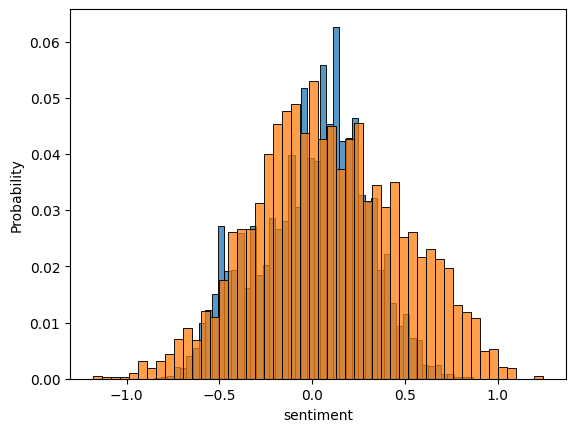

In [86]:
sns.histplot(articles['sentiment'], stat='probability', bins=50)
sns.histplot(paired_articles['diff'], stat='probability', bins=50)

In [87]:
# word_coeff = word_coeff[3:]
ngrams_to_remove = ['doesnt', 'ive', 'xxxtentacions', 'wasnt', 'wrlds']
word_coeff = word_coeff[~word_coeff.index.isin(ngrams_to_remove)]

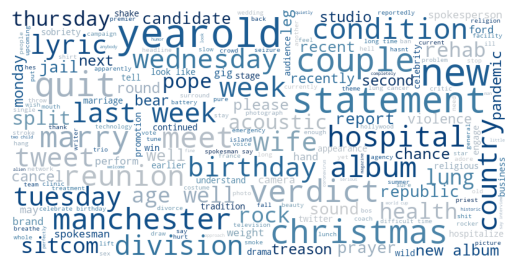

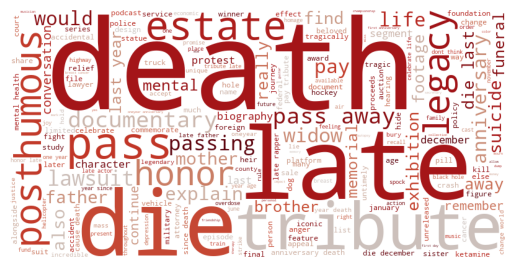

In [88]:
from wordcloud import WordCloud


def plot_word_cloud(word_dict: dict, max_font_size: float = 200, colormap: str = 'viridis', fig_name: str | None = None):

    wordcloud = WordCloud(
        width=800, height=400, random_state=42, background_color='white',
        max_font_size=max_font_size, relative_scaling=1, colormap=colormap
    ).generate_from_frequencies(word_dict)

    fig, ax = plt.subplots()
    ax.imshow(wordcloud)
    ax.axis('off')
    if fig_name:
        plt.savefig(f'plots/{fig_name}.pdf', bbox_inches='tight', pad_inches=0)


from matplotlib.colors import LinearSegmentedColormap

# Darken the colormap
def darken_cmap(cmap, factor):
    colors = cmap(np.linspace(0, 1, 256))
    new_colors = colors * factor
    new_cmap = LinearSegmentedColormap.from_list(cmap.name + "_darkened", new_colors)
    return new_cmap


pre_words_dict = word_coeff[word_coeff > 0].to_dict()
post_words_dict = (-word_coeff[word_coeff < 0]).to_dict()

max_abs_coeff = word_coeff.abs().max()
max_font_size_pre = abs(word_coeff.max()) / max_abs_coeff * 200
max_font_size_post = abs(word_coeff.min()) / max_abs_coeff * 200

factor = .8
blues_cmap = plt.get_cmap('Blues')
blues_cmap = darken_cmap(blues_cmap, factor)

reds_cmap = plt.get_cmap('Reds')
reds_cmap = darken_cmap(reds_cmap, factor)

plot_word_cloud(pre_words_dict, max_font_size=max_font_size_pre, colormap=blues_cmap, fig_name='wordcloud_pre')
plot_word_cloud(post_words_dict, max_font_size=max_font_size_post, colormap=reds_cmap, fig_name='wordcloud_post')

### NMF

In [89]:
import pickle

# Create a list of the topic numbers we want to try
topic_nums = range(1, 25 + 1)
# topic_nums = range(6, 11 + 1)
# topic_nums = range(5, 15 + 1)

In [90]:
# from tqdm import tqdm
# from gensim.corpora.dictionary import Dictionary
# from gensim.models.nmf import Nmf
# from gensim.models.coherencemodel import CoherenceModel


# # Create a dictionary
# texts = articles['body_cleaned'].str.split(' ')
# dictionary = Dictionary(texts)

# # Filter out extremes to limit the number of features
# dictionary.filter_extremes(no_below=.01)

# # Create the bag-of-words format (list of (token_id, token_count))
# corpus = [dictionary.doc2bow(text) for text in texts]

# # Run the nmf model and calculate the coherence score for each number of topics
# coherence_scores = {}

# for num in tqdm(topic_nums):

#     nmf = Nmf(
#         corpus=corpus,
#         num_topics=num,
#         id2word=dictionary,
#         passes=5,
#         kappa=.1,
#         minimum_probability=.01,
#         w_max_iter=300,
#         w_stop_condition=.0001,
#         h_max_iter=100,
#         random_state=42
#     )
    
#     # Run the coherence model to get the score
#     cm = CoherenceModel(
#         model=nmf,
#         texts=texts,
#         dictionary=dictionary,
#         coherence='c_v'
#     )
    
#     coherence_scores[num] = cm.get_coherence()

# with open('data/coherence_scores.pkl', 'wb') as f:
#     pickle.dump(coherence_scores, f)

Best-scoring: k = 11, C_v = 0.5250
Chosen: k = 7, C_v = 0.5087


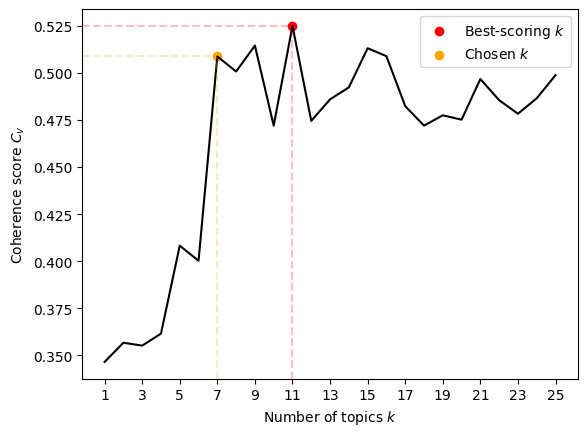

In [91]:
with open('data/coherence_scores.pkl', 'rb') as f:
    coherence_scores = pickle.load(f)

# Chosen k
n_components = 7

# Get the number of topics with the highest coherence score
max_coherence = max(coherence_scores, key=coherence_scores.get)

print(f'Best-scoring: k = {max_coherence}, C_v = {coherence_scores[max_coherence]:.4f}')
print(f'Chosen: k = {n_components}, C_v = {coherence_scores[n_components]:.4f}')


fig, ax = plt.subplots()
ax.plot(coherence_scores.keys(), coherence_scores.values(), color='k')

# best score
ax.scatter(max_coherence, coherence_scores[max_coherence], color='r', label='Best-scoring $k$')
ax.axvline(x=max_coherence, ymax=.95, color='r', alpha=.25, linestyle='--')
ax.axhline(y=coherence_scores[max_coherence], xmax=.42, color='r', alpha=.25, linestyle='--')

# chosen
ax.scatter(n_components, coherence_scores[n_components], color='orange', label='Chosen $k$')
ax.axvline(x=n_components, ymax=.87, color='orange', alpha=.25, linestyle='--')
ax.axhline(y=coherence_scores[n_components], xmax=.27, color='orange', alpha=.25, linestyle='--')

ax.set_xlabel('Number of topics $k$')
ax.set_ylabel('Coherence score $C_v$')
ax.set_xticks(range(min(topic_nums), max(topic_nums) + 1, 2))
ax.legend()
plt.savefig('plots/coherence.pdf', bbox_inches='tight', pad_inches=0)

In [92]:
texts = articles['body_cleaned']

# Create the tfidf weights
tfidf_vectorizer = TfidfVectorizer(
    min_df=.01,
    ngram_range=(1, 2)
)

tfidf = tfidf_vectorizer.fit_transform(texts)
tfidf.shape

(7600, 2753)

In [93]:
from sklearn.decomposition import NMF


# Run the nmf model
nmf = NMF(
    n_components=n_components,
    init='nndsvd',
    max_iter=1000,
    random_state=42
)

W = nmf.fit_transform(tfidf)
H = nmf.components_

print(f'W(n_samples, n_components):\t{W.shape}')
print(f'H(n_components, n_features):\t{H.shape}')

W(n_samples, n_components):	(7600, 7)
H(n_components, n_features):	(7, 2753)


In [94]:
n_top_words = 20

feature_names = tfidf_vectorizer.get_feature_names_out()
topic_dict = {}
for t, topic in enumerate(H):
    topic_dict[t] = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]

topic_df = pd.DataFrame(topic_dict).T
topic_df[f'top{n_top_words}_ngrams'] = topic_df.apply(lambda x: ', '.join(x), axis=1)
topics = range(1, n_components + 1)
topic_df.index = topics
topic_df.index.name = 'topic'
topic_df['theme'] = ['cinema', 'public affairs, leadership', 'music', 'family, tribute', 'justice, treason', 'crime, drugs', 'sport']

# Create a df with only the created topics and topic num
topic_df = topic_df[[f'top{n_top_words}_ngrams', 'theme']]
topic_df.to_csv('tables/topics.tsv', sep='\t')
topic_df

,top20_ngrams,theme
topic,,
1,"film, say, like, get, think, actor, movie, rea...",cinema
2,"president, say, leader, country, former, pope,...","public affairs, leadership"
3,"album, song, music, record, release, new, rock...",music
4,"family, love, mother, son, die, wife, daughter...","family, tribute"
5,"court, treason, special court, sentence, case,...","justice, treason"
6,"drug, lawsuit, death, claim, truck, report, al...","crime, drugs"
7,"game, team, player, season, quarterback, win, ...",sport


Topic
1    1754
2    1114
3    1240
4    1553
5     215
6     788
7     936
Name: count, dtype: int64

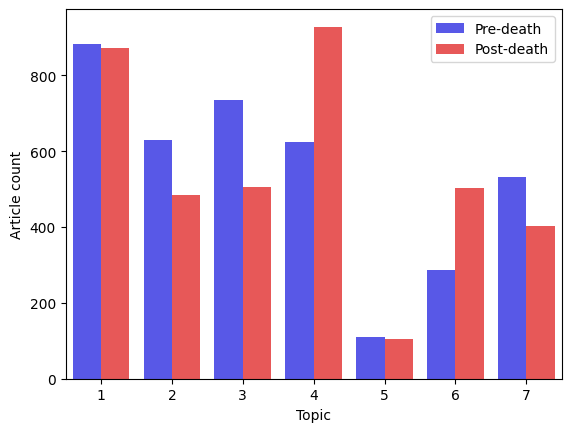

In [95]:
# Assigining a topic to each document
articles['Topic'] = W.argmax(axis=1)
articles['Topic'] += 1

fig, ax = plt.subplots()
sns.countplot(data=articles, x='Topic', hue='Period', palette=PALETTE, alpha=ALPHA, ax=ax)
ax.set_ylabel('Article count')
ax.legend(title='')
plt.savefig('plots/topic_counts.pdf', bbox_inches='tight', pad_inches=0)
# articles.groupby(['Topic', 'Period']).size()
articles['Topic'].value_counts().sort_index()

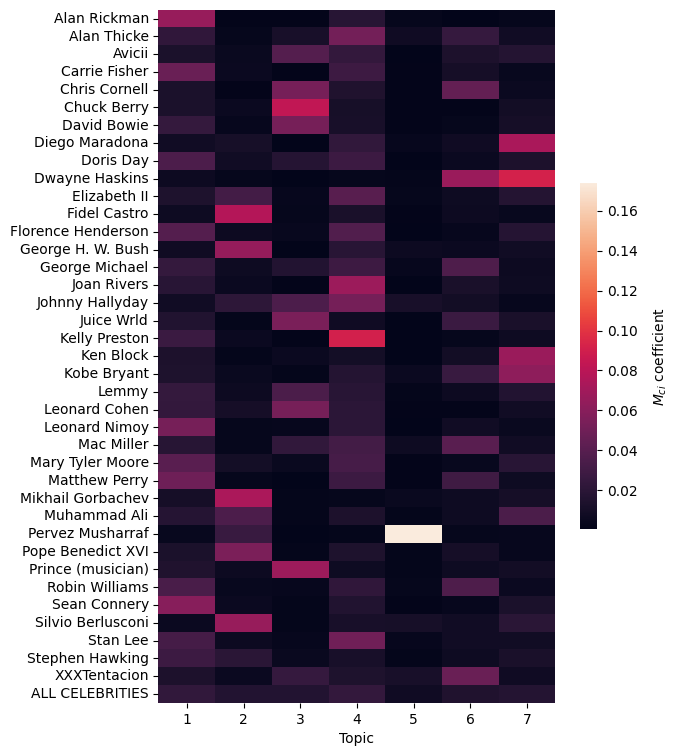

In [96]:
art_topics = pd.DataFrame(W, index=articles['name'], columns=topics)
celeb_topics = art_topics.groupby('name').mean()
celeb_topics = pd.concat([celeb_topics, pd.DataFrame(W.mean(axis=0), index=topics, columns=['ALL CELEBRITIES']).T], axis=0)

fig, ax = plt.subplots(figsize=figsize_big)
sns.heatmap(data=celeb_topics, cmap='rocket', ax=ax, cbar_kws={'shrink': .5})
cbar = ax.collections[0].colorbar
cbar.set_label('$M_{ci}$ coefficient', labelpad=10)
ax.set_xlabel('Topic')
ax.set_ylabel('')
plt.savefig('plots/topic_celeb.pdf', bbox_inches='tight', pad_inches=0)

In [97]:
celeb_topics_pre = art_topics[:3800].groupby('name').mean()
celeb_topics_pre = pd.concat([celeb_topics_pre, pd.DataFrame(W[:3800].mean(axis=0), index=topics, columns=['ALL CELEBRITIES']).T], axis=0)

celeb_topics_post = art_topics[3800:].groupby('name').mean()
celeb_topics_post = pd.concat([celeb_topics_post, pd.DataFrame(W[3800:].mean(axis=0), index=topics, columns=['ALL CELEBRITIES']).T], axis=0)

celeb_topics_diff = celeb_topics_post - celeb_topics_pre
celeb_topics_diff.head()

,1,2,3,4,5,6,7
Alan Rickman,0.002106,-0.001231,0.000156,0.016451,0.001951,0.000187,-0.002388
Alan Thicke,-0.011791,-0.000484,-0.022315,0.026064,0.010297,0.041212,-0.007801
Avicii,0.006636,-0.003637,-0.005107,0.022781,-0.000583,0.003598,0.008416
Carrie Fisher,-0.018335,0.000074,0.000784,0.033451,-0.000165,0.016195,0.001032
Chris Cornell,-0.011618,-0.000370,-0.040956,0.017791,-0.001825,0.084876,-0.002071


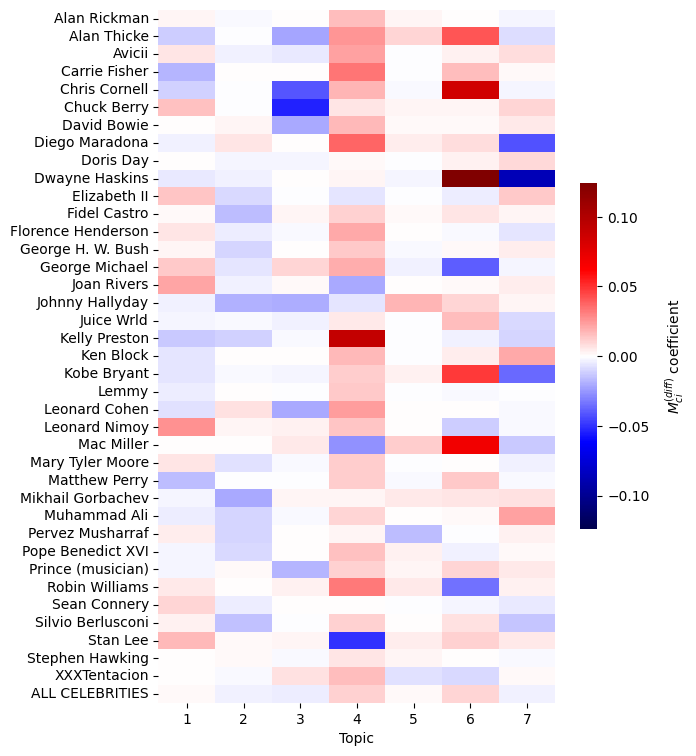

In [98]:
cmap = 'seismic'
# cmap = 'coolwarm'
# cmap = 'vlag'

lim = max(abs(celeb_topics_diff.min().min()), abs(celeb_topics_diff.max().max()))

fig, ax = plt.subplots(figsize=figsize_big)
sns.heatmap(data=celeb_topics_diff, cmap=cmap, vmin=-lim, vmax=lim, ax=ax, cbar_kws={'shrink': .5})
cbar = ax.collections[0].colorbar
cbar.set_label('$M_{ci}^{(diff)}$ coefficient', labelpad=10)
ax.set_xlabel('Topic')
ax.set_ylabel('')
plt.savefig('plots/topic_celeb_diff.pdf', bbox_inches='tight', pad_inches=0)

In [99]:
# Example of article where the MORE NEWS section at the end is included
articles[articles['uri'] == '1263884675']

,name,Period,uri,datetime,data_type,sim,url,title,body,shares,...,source_importance_rank,source_alexa_global_rank,source_alexa_country_rank,pre_end_max,post_start_min,Source country,keywords,body_cleaned,Topic,t
7501,XXXTentacion,Post-death,1263884675,2019-09-19 03:26:00+00:00,news,0.831373,https://www.digitalmusicnews.com/2019/09/18/xx...,XXXTentacion Murder Suspect Seeks Bond to Get ...,One of the individuals who's been accused of o...,{},...,312951,40144.0,10367.0,2018-06-17,2018-07-18,United States,['XXXTentacion'],one individual whos accuse organize carry murd...,6,False
